In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from saxs_data_processing import io, manipulate, target_comparison, subtract
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

import altair as alt

import plotly.express as px

## User parameter setup

List of all background files to use. Data loading function will find associated data files in the same directory as backgrounds.

In [32]:
background_fps = ['/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_05_StoberRandomCampaignV2/03210_B9-T1_Ethanol_background__000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_07_randomcampaignV3/data/03218_D1-T1_Ethanol_background_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_11_randomV3_round2/03289_H6-T2_EtOH_background_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_15_Highlights_replicates/03357_D5-T2_Background_1_EtOH_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_17_randomBaselineV4/data/03439_C1-T2_EtOH_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_11_05_optimizationRound1/03533_F9-T1_Ethanol_background_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_11_12_optimizationRound2/data/03619_B11-T2_Ethanol_background_1_000.dat']

Select q ranges. Right now this relies on manual q range selection to a certain extent. We subtract background and fit the spline on a larger q-range, then evaluate the spline on a subset of the larger q range to avoid spline edge effects.

In [33]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1024 # number of grid points to interpolate q on.

Select target particle parameters. Target is spherical particles with radius r and polydispersity pdi

In [34]:
target_r_nm = 60
target_r_angs = target_r_nm*10
target_pdi = 0.08
sld_silica = 8.575
sld_etoh = 9.611

Set processing and optimization parameters for distance calculation

In [35]:
# SavGol denoise filter parameters
savgol_n = 15
savgol_order = 3
# minimum data length - data with less than ~100 data points is due to valid data selection step in subtraction and is likley too noisy to do anything with.
min_data_len = 100

# spline fit parameters
s = 0.05
k = 3

#scale parameters
n_avg = 100

# Amplitude-phase distance parameters
optim = "DP"
grid_dim = 10

## load data

In [36]:
sample_data, uuid2bkg = io.load_biocube_data_with_background(background_fps, 24)

/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/io.py:150: UserWarning:

Duplicate UUID found for b8953350-d5ad-4c99-b929-ebfe8febd0df. Check your file naming

/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/io.py:150: UserWarning:

Duplicate UUID found for ea0d2ca6-8818-45f8-b5e3-04858133284a. Check your file naming

/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/io.py:150: UserWarning:

Duplicate UUID found for 0ec4dd81-7487-4689-96b9-b0f646a2047d. Check your file naming



In [37]:
sample_data['d298bae0-5f86-4a29-b399-111644195748']

(            q             I          sig
 0    0.000076  9.078300e+06  2413.508053
 1    0.000229  8.492859e+06  1650.663180
 2    0.000382  7.098983e+06   954.464023
 3    0.000535  5.476718e+06   838.342871
 4    0.000688  4.123638e+06   626.087286
 ..        ...           ...          ...
 900  0.137607  0.000000e+00     0.247154
 901  0.137760  0.000000e+00     0.282462
 902  0.137913  0.000000e+00     0.247155
 903  0.138066  0.000000e+00     0.659084
 904  0.138219  0.000000e+00     0.659086
 
 [905 rows x 3 columns],
 {'EDF_DataBlockID': '0.Image.Psd',
  'EDF_BinarySize': 4366944,
  'EDF_HeaderSize': 3584,
  'ByteOrder': 'LowByteFirst',
  'DataType': 'FloatValue',
  'Dim_1': 1028,
  'Dim_2': 1062,
  'Image': 0,
  'HeaderID': 'EH:000000:000000:000000',
  'Size': 4366944,
  'BIO_BUFFER': None,
  'BIO_CELL_TEMP': 25.17,
  'BIO_CODE': 'None',
  'BIO_CONC': 0.0,
  'BIO_DESCRIPTION': 'd298bae0-5f86-4a29-b399-111644195748',
  'BIO_PROJECT': 'None',
  'BIO_RUN_NUMBER': 3635,
  'BIO_SAM

## Run full processing pipeline

/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning:

No hiq lim satisfying threshold found, setting value to q max

/tmp/ipykernel_255492/744074597.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:137: UserWarning:

Insufficient data points in q range with scattering. Check data quality



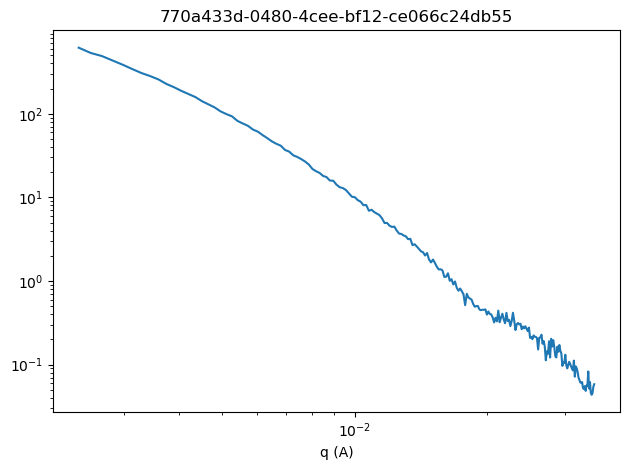

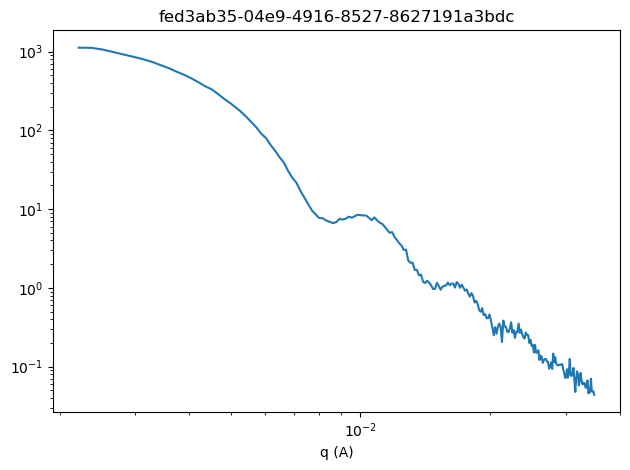

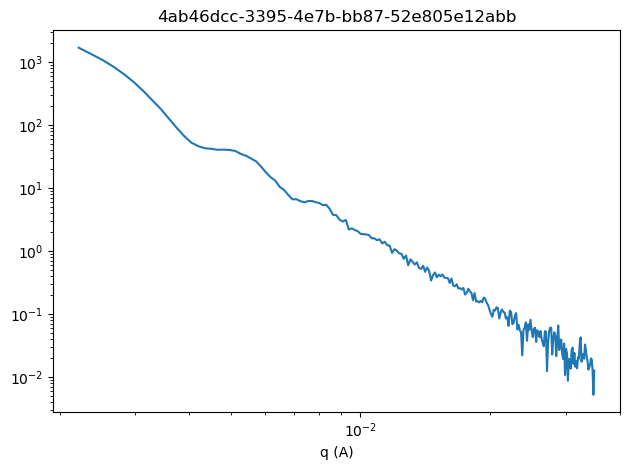

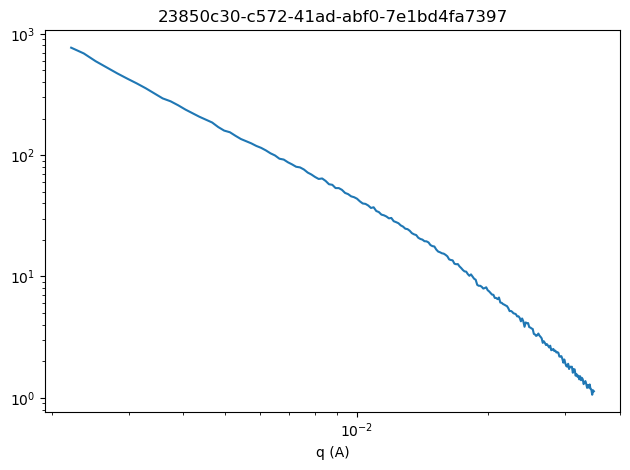

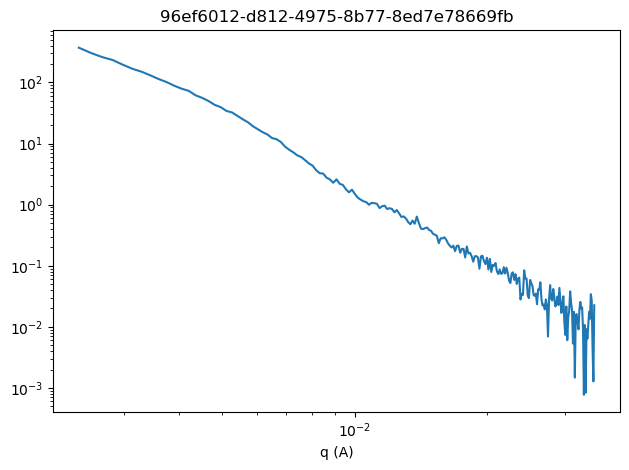

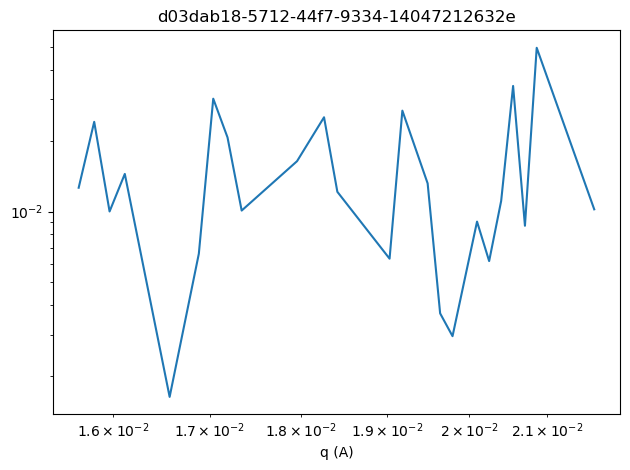

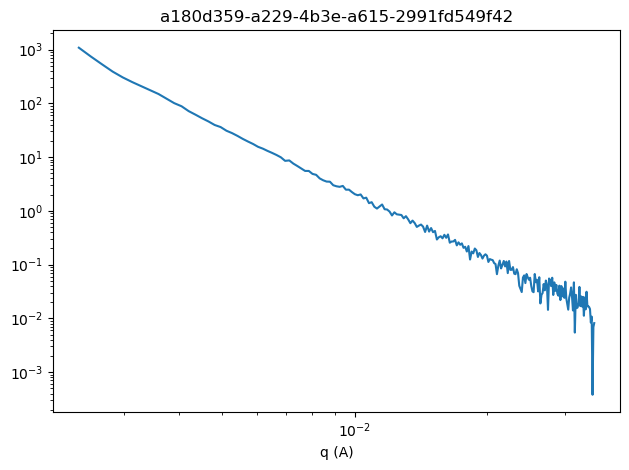

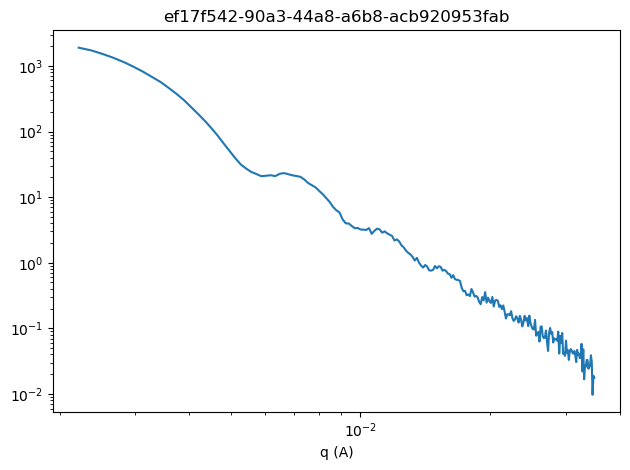

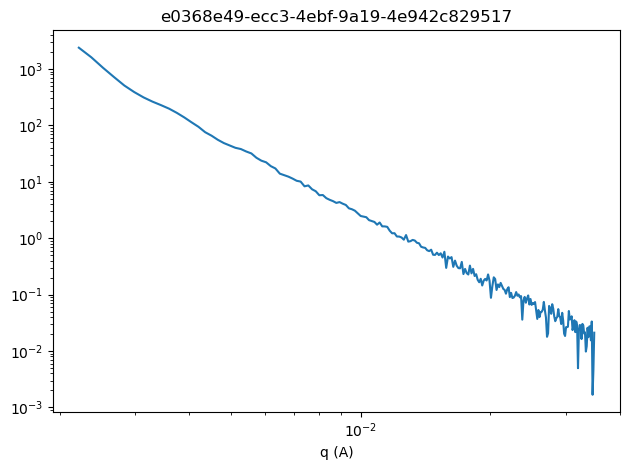

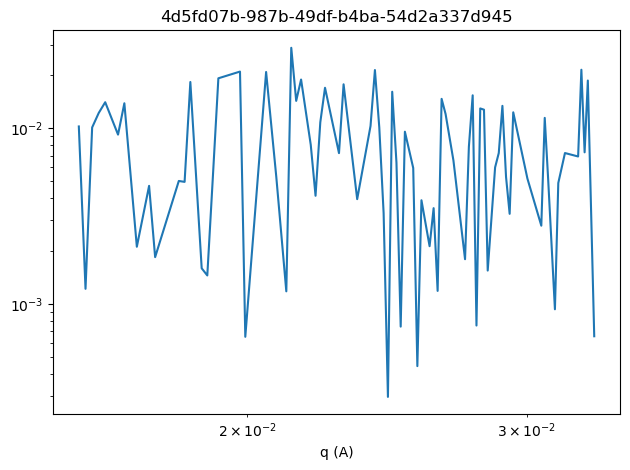

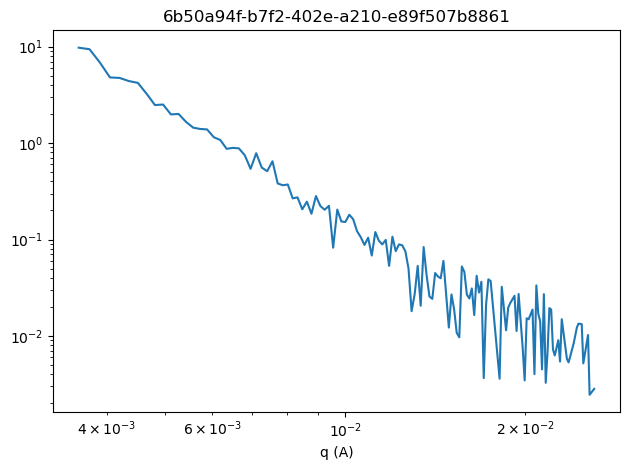

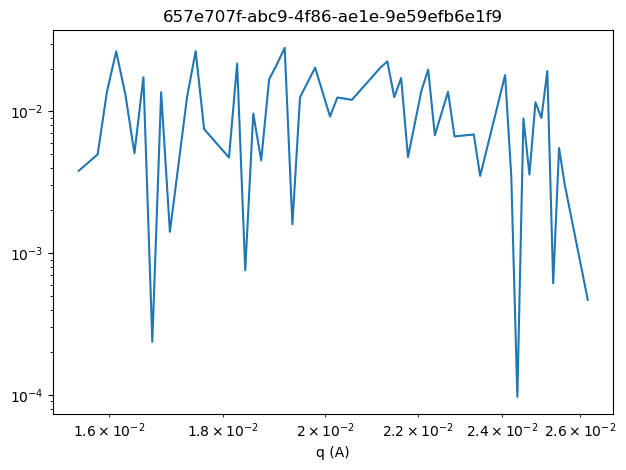

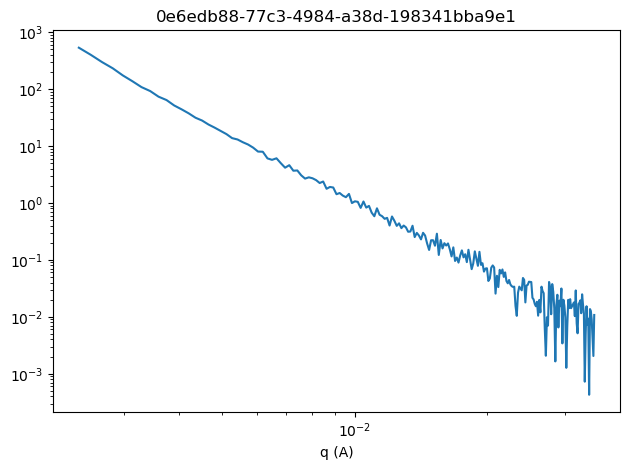

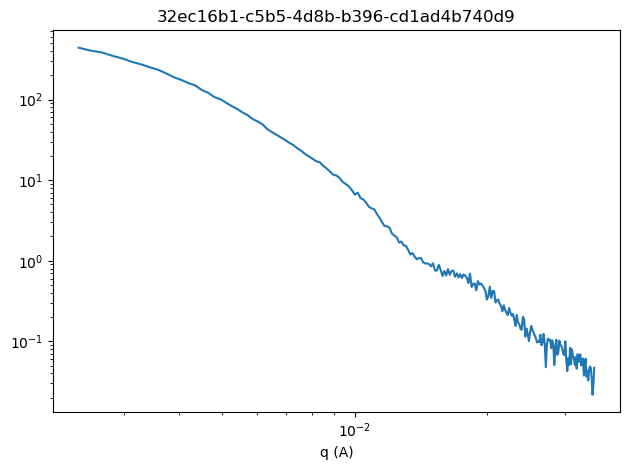

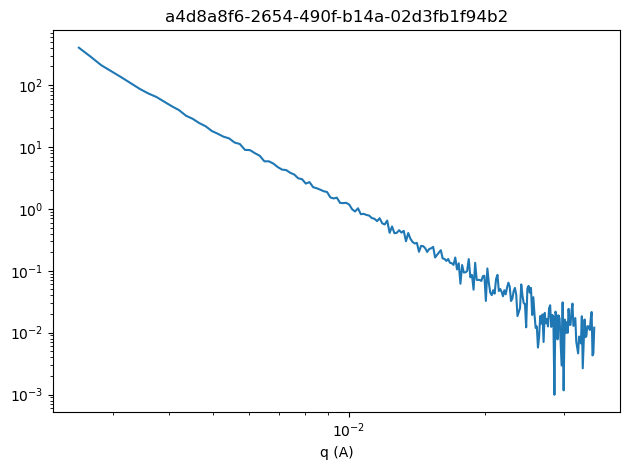

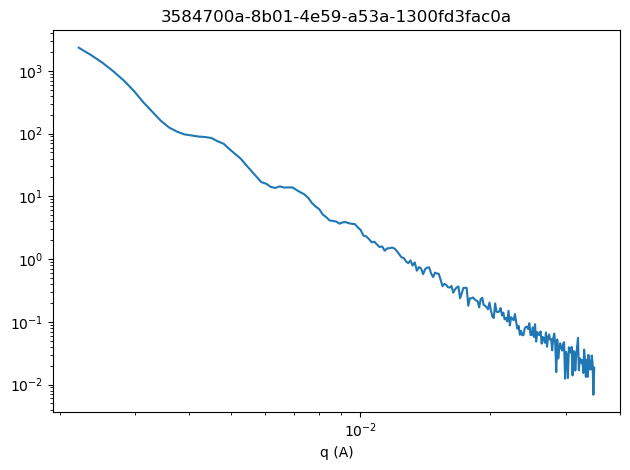

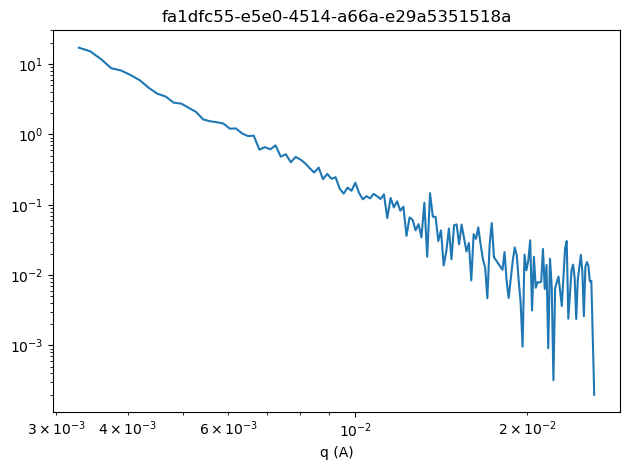

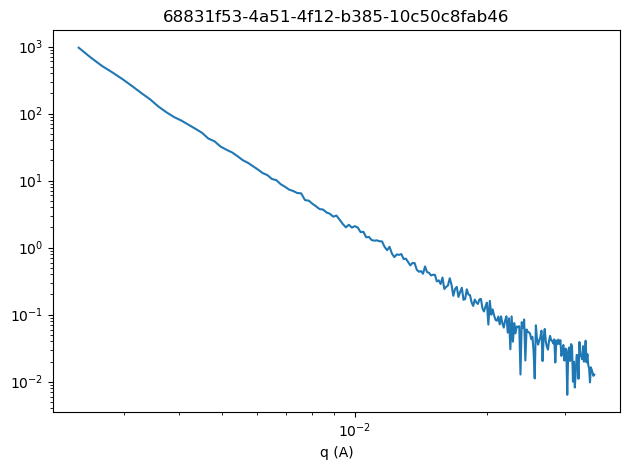

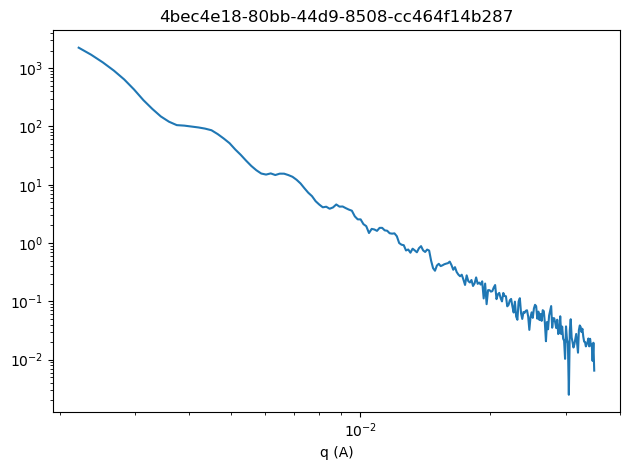

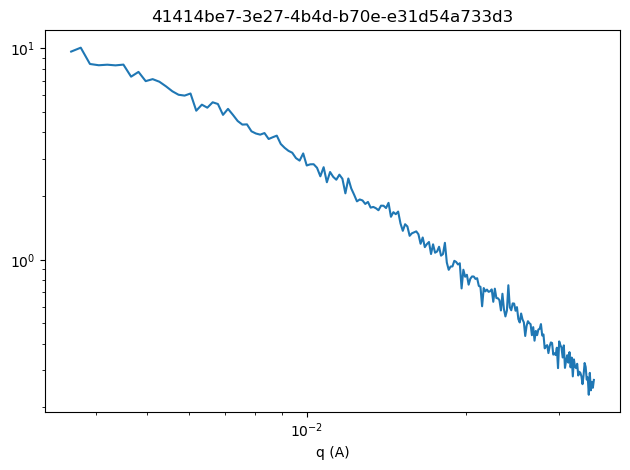

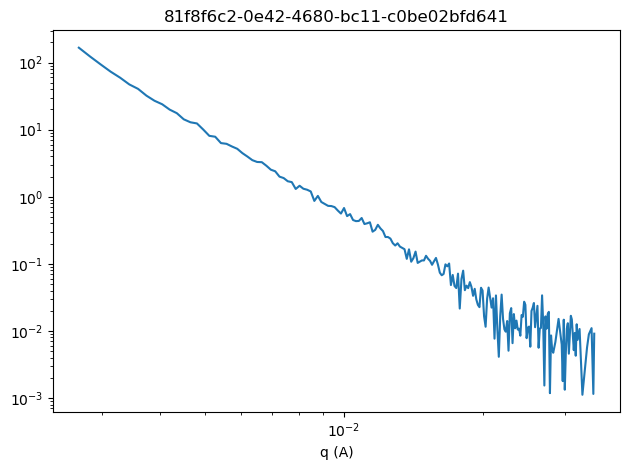

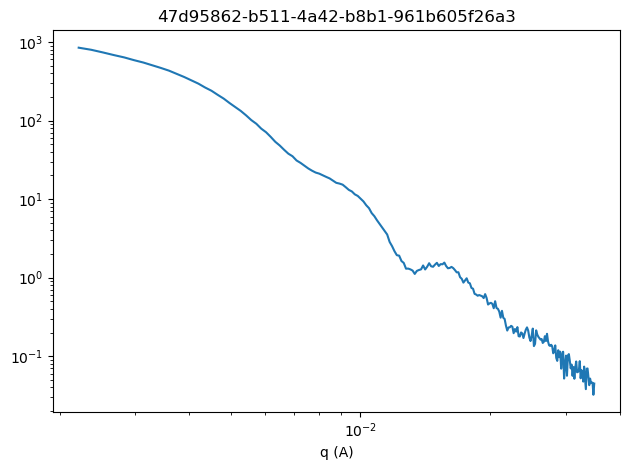

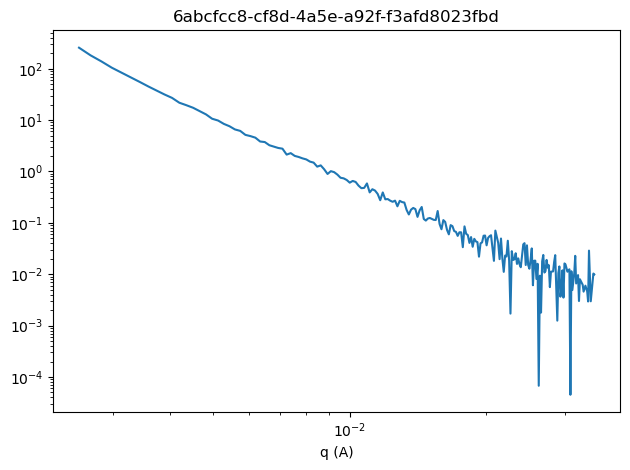

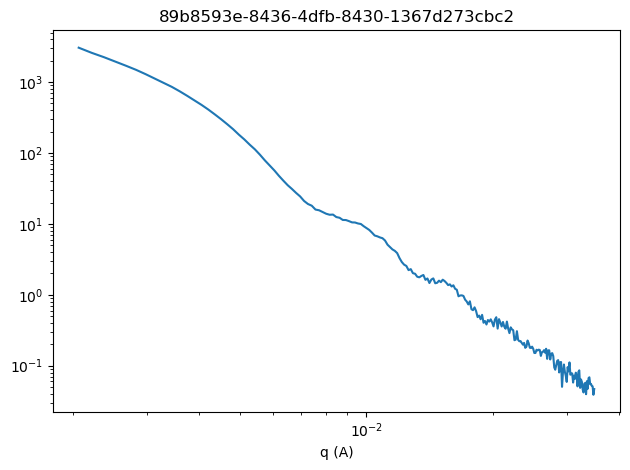

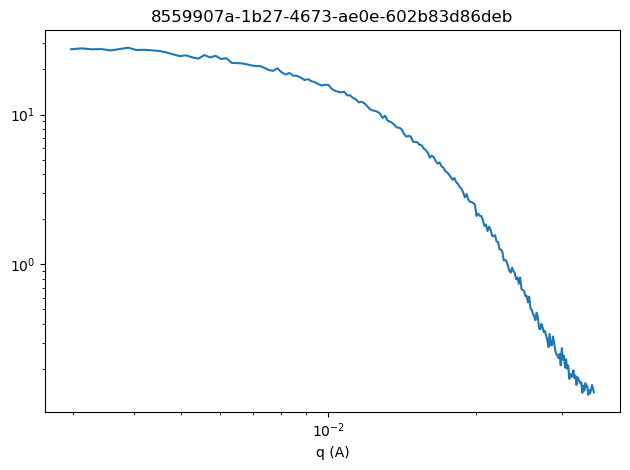

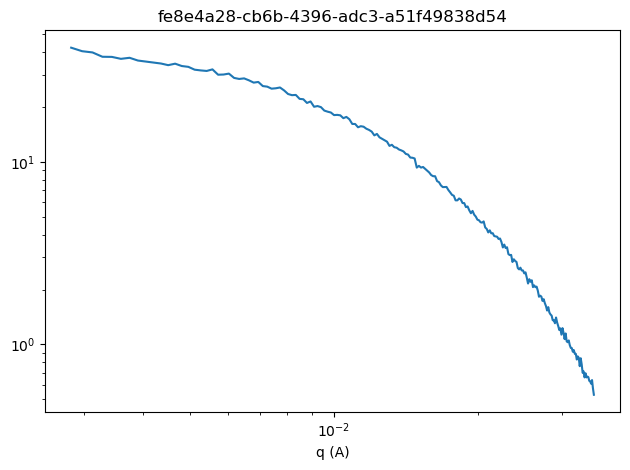

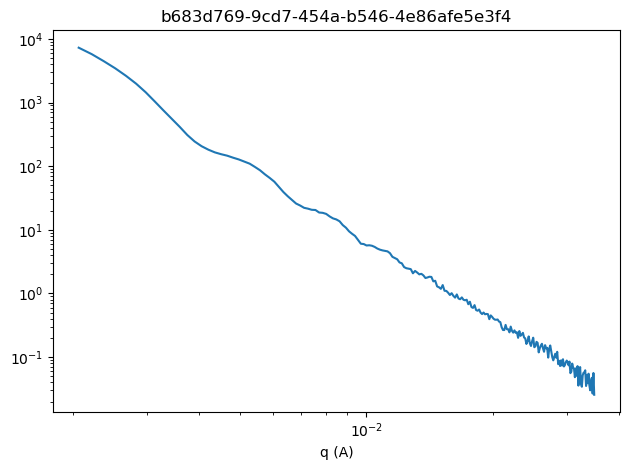

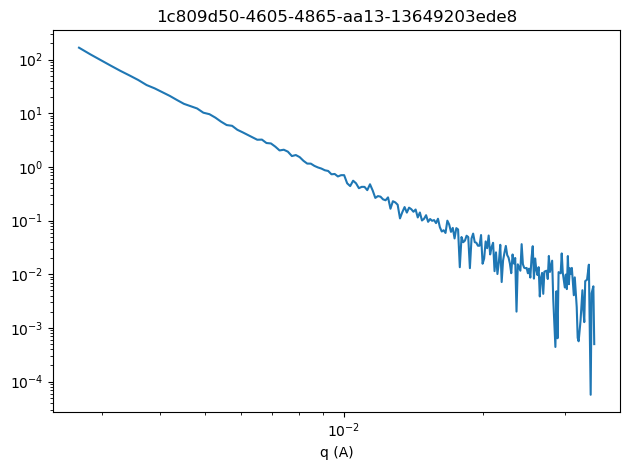

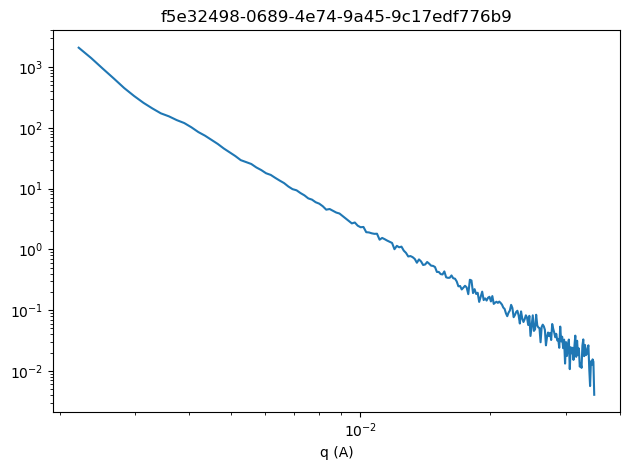

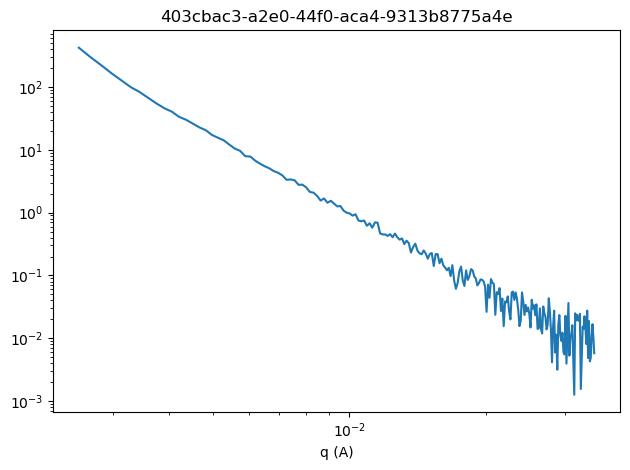

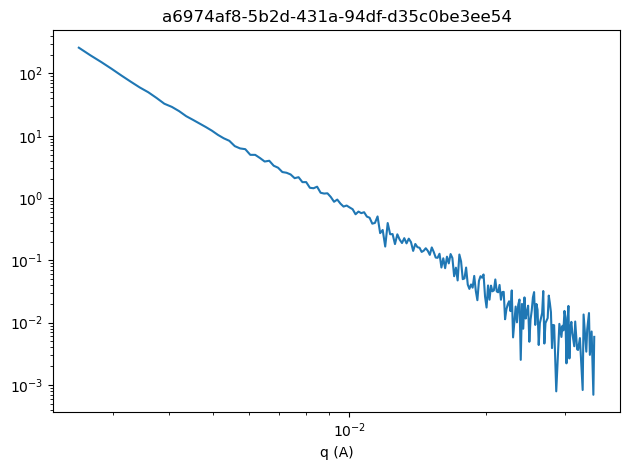

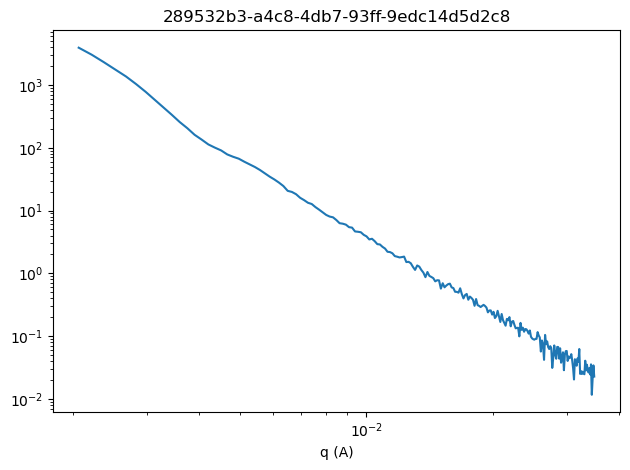

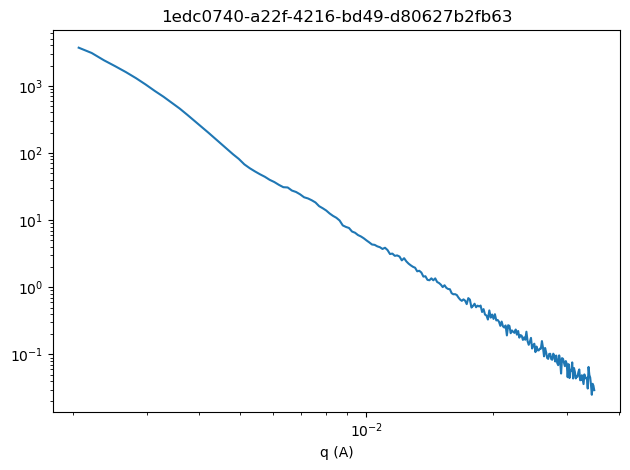

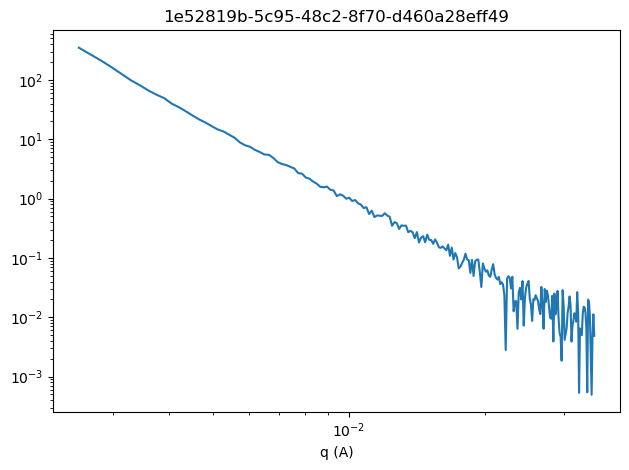

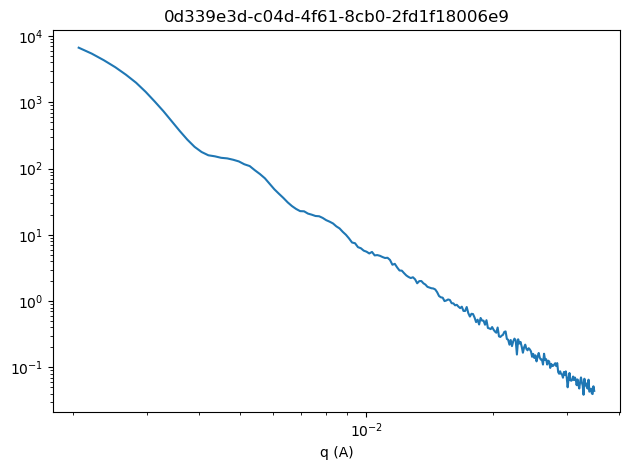

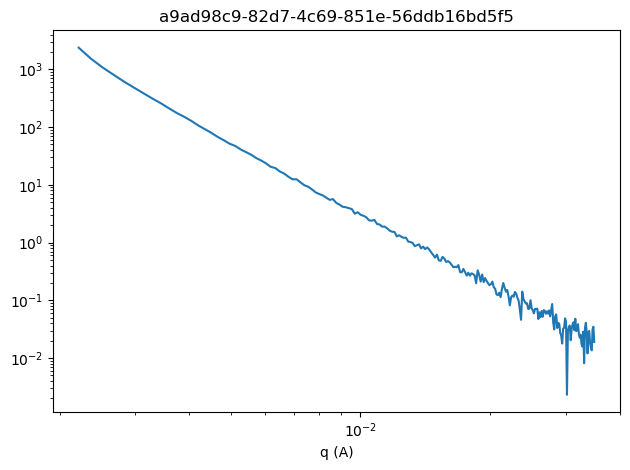

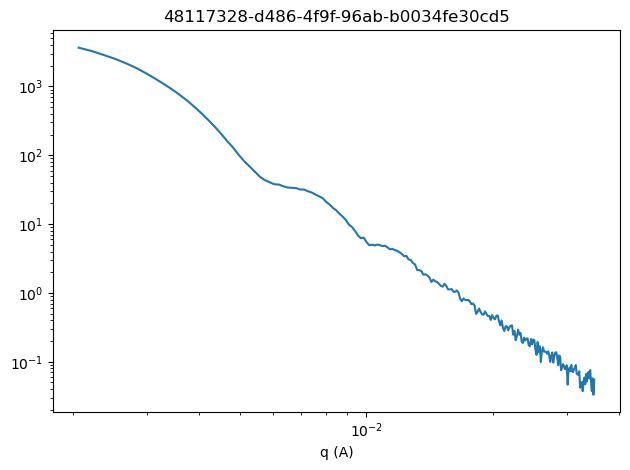

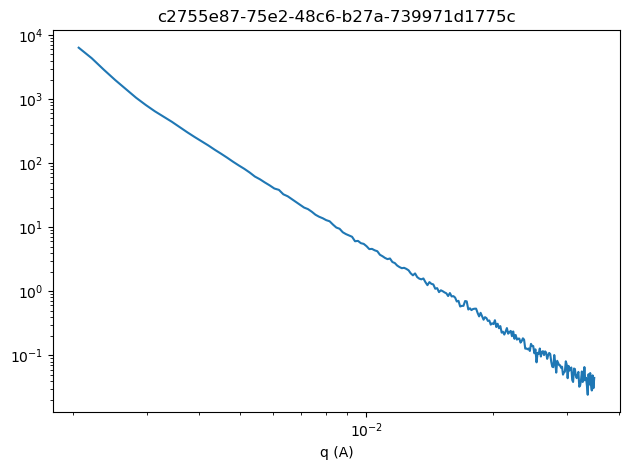

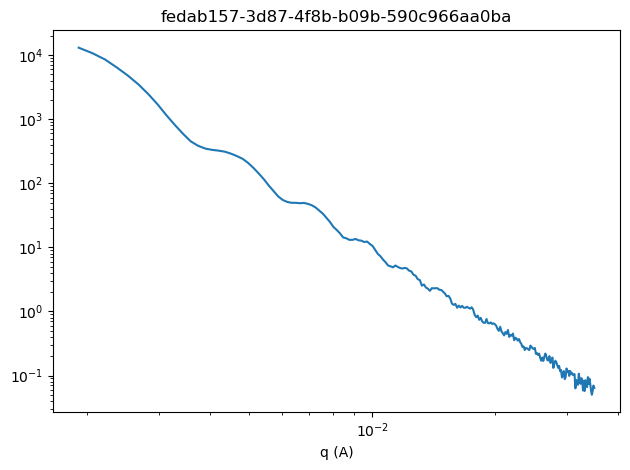

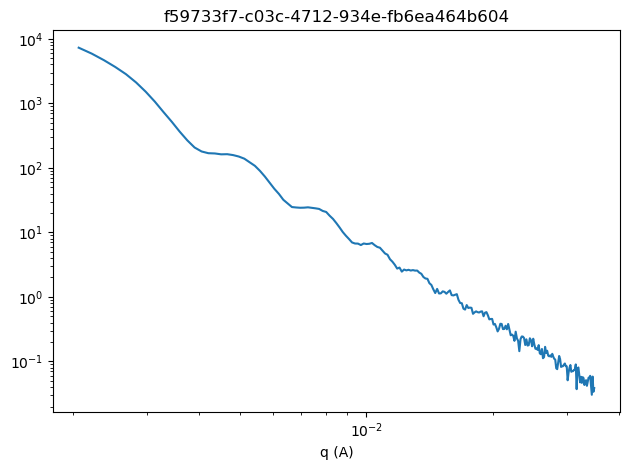

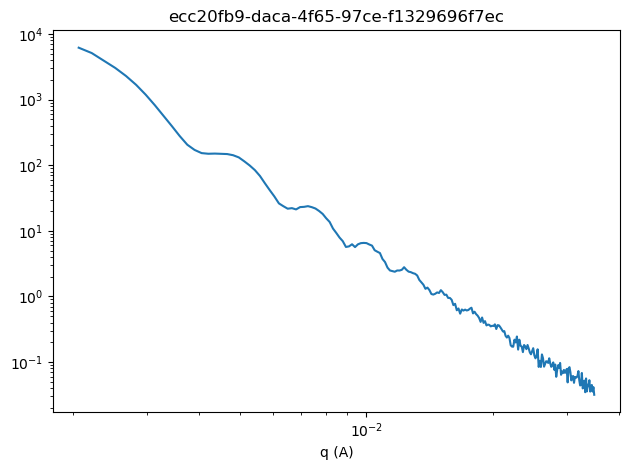

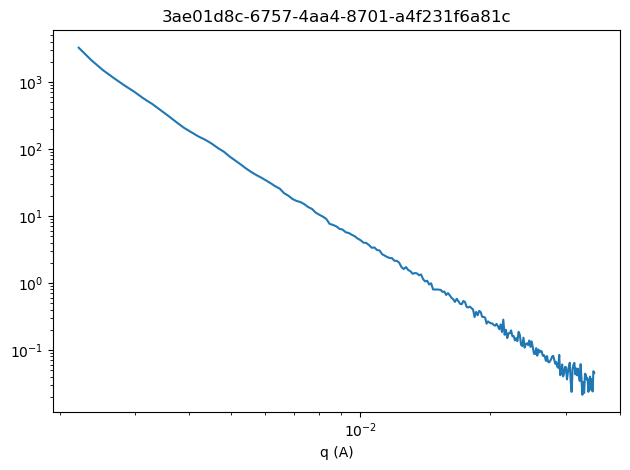

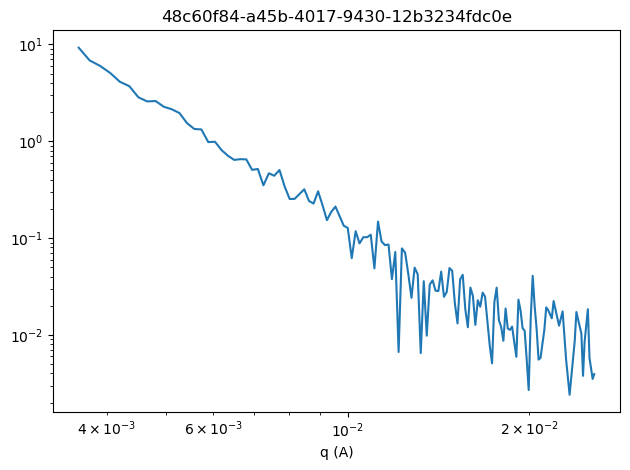

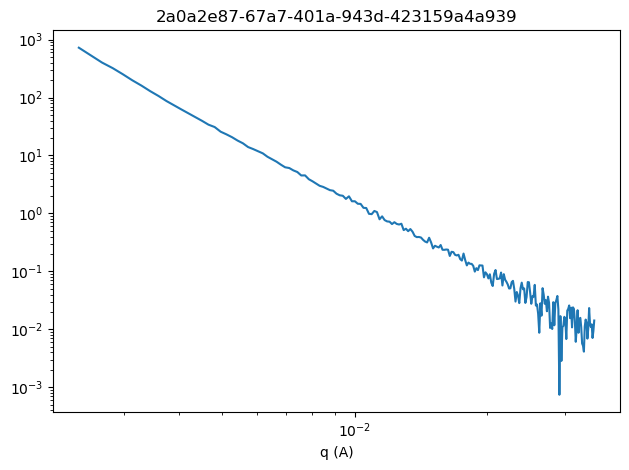

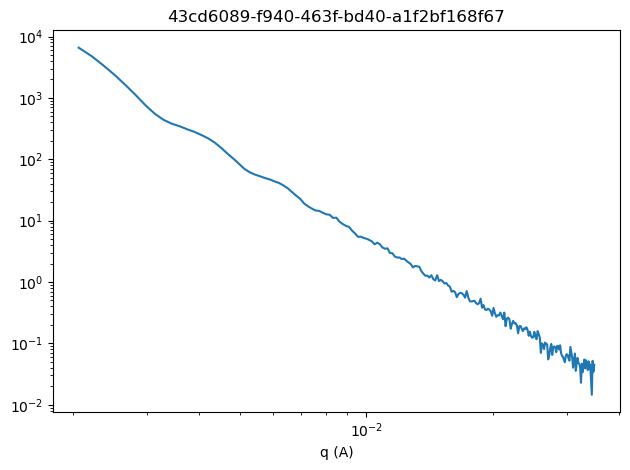

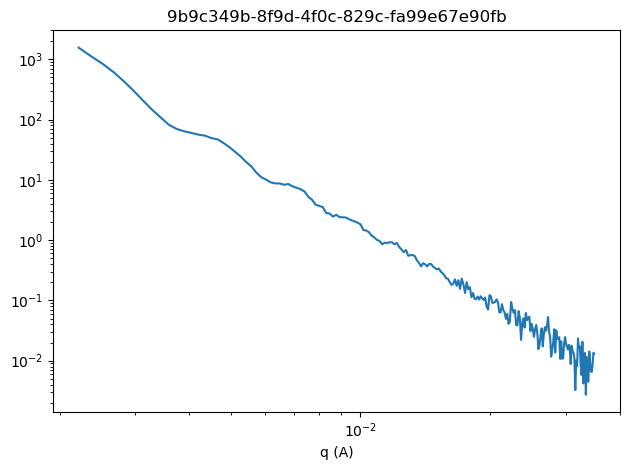

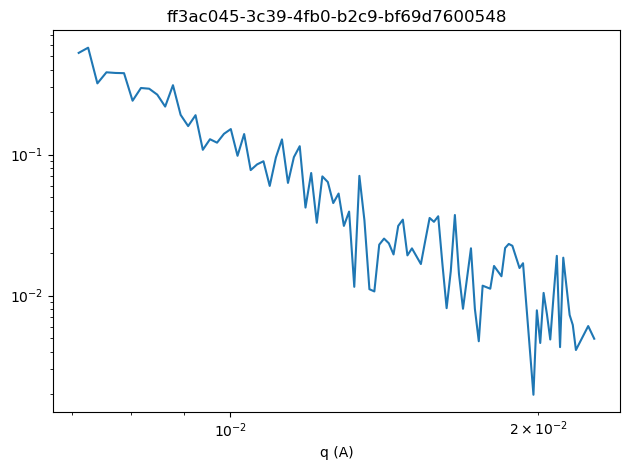

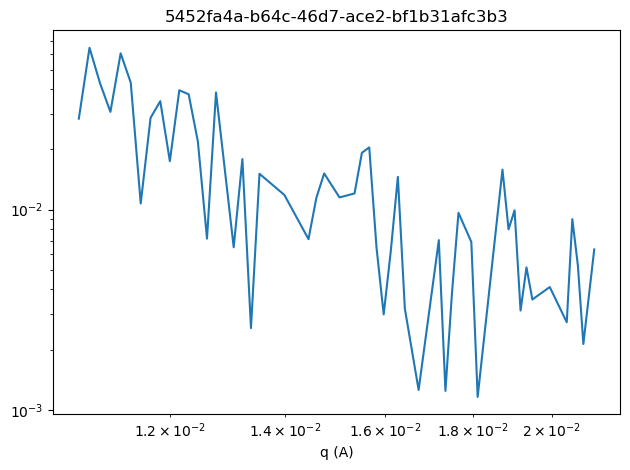

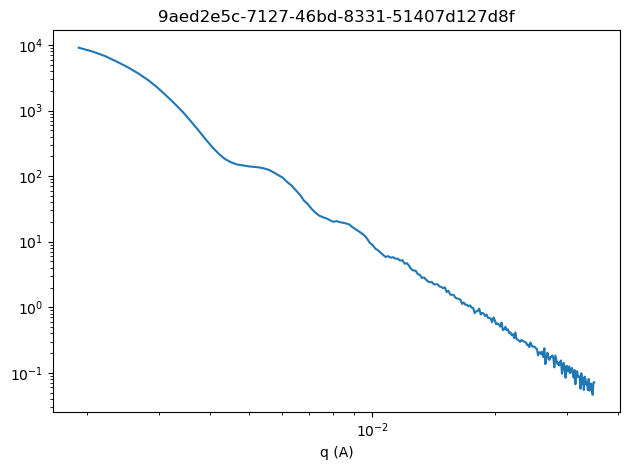

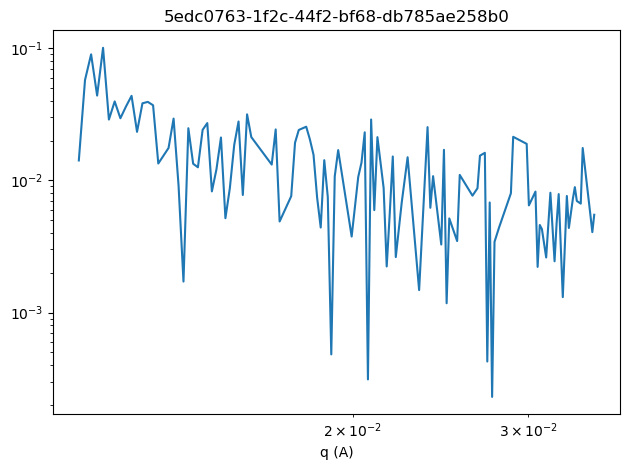

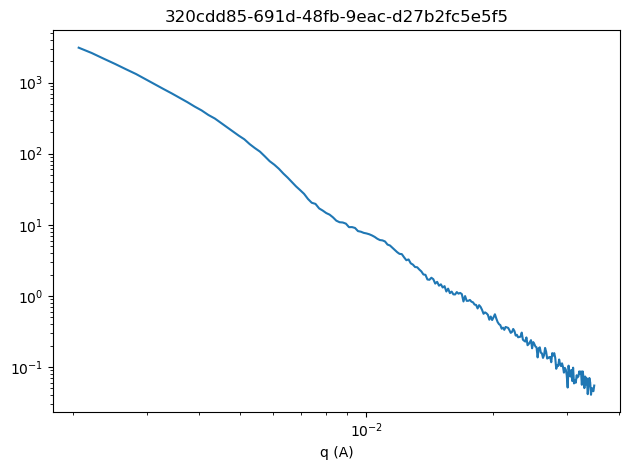

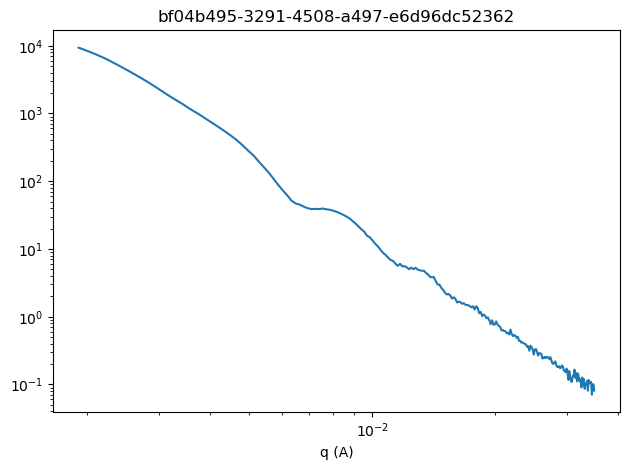

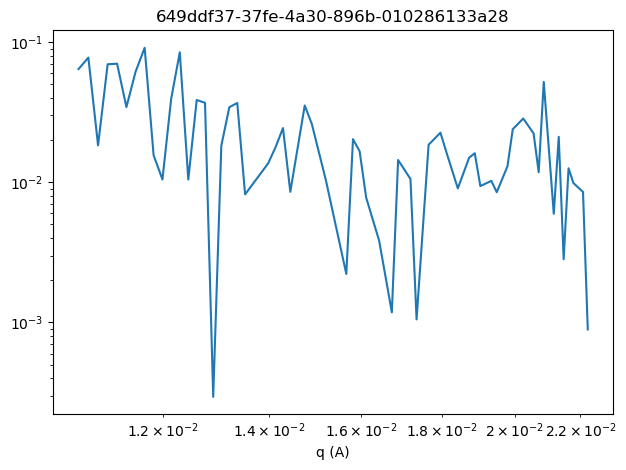

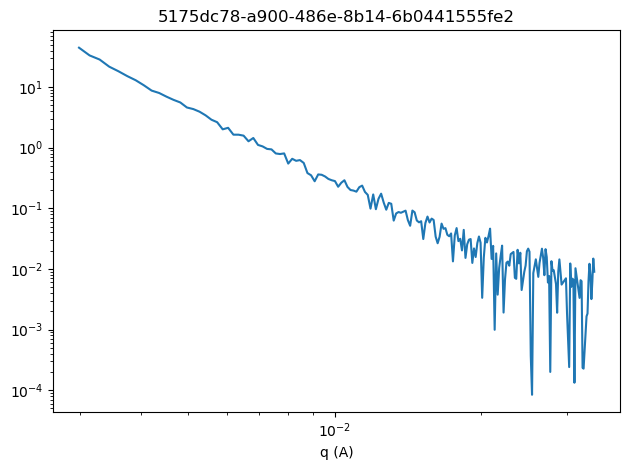

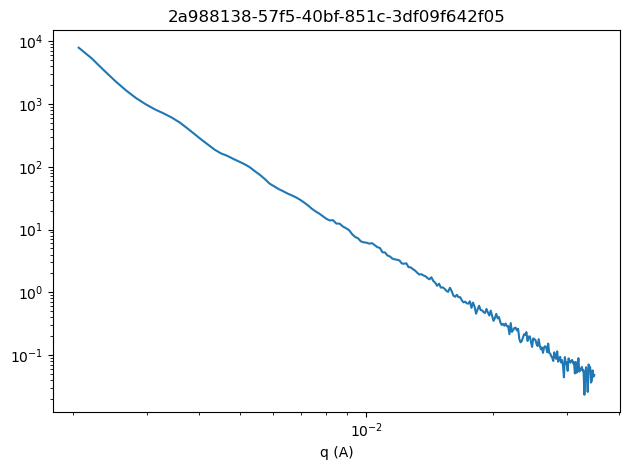

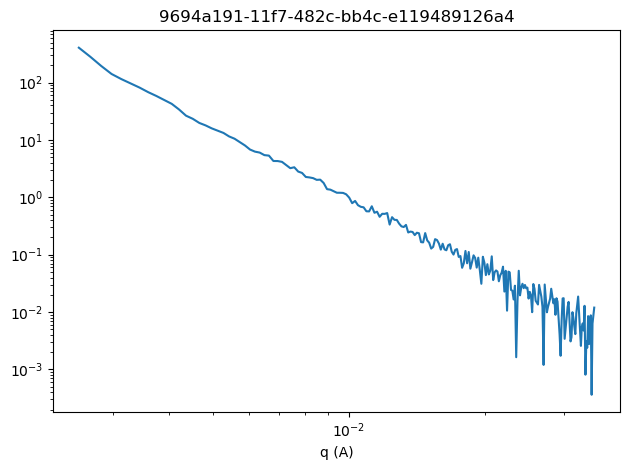

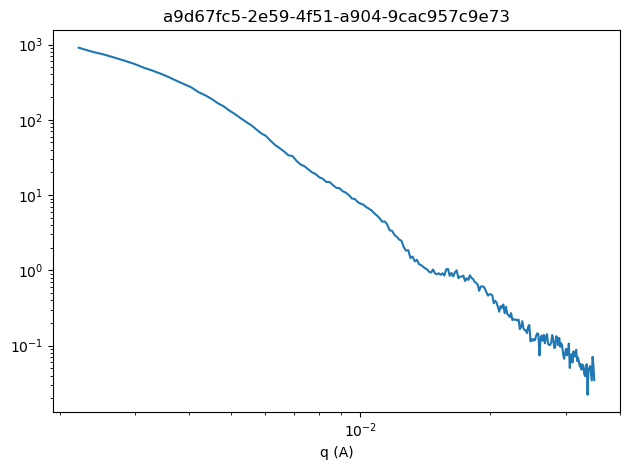

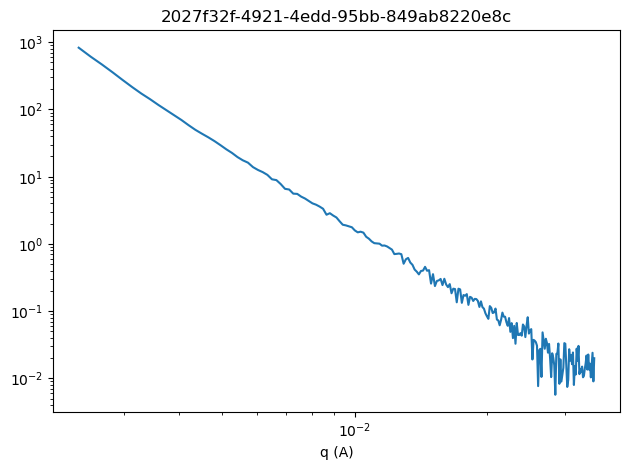

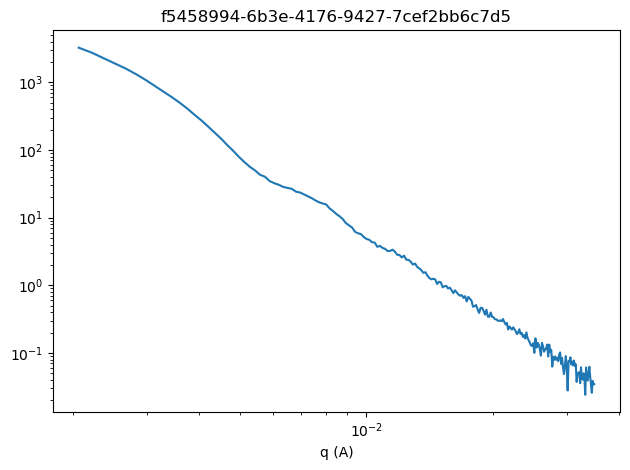

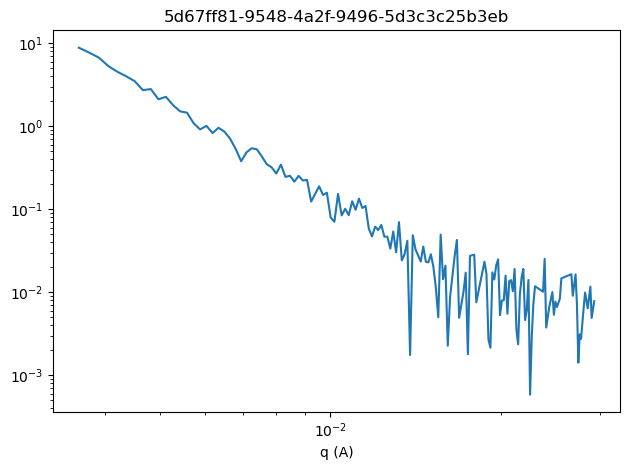

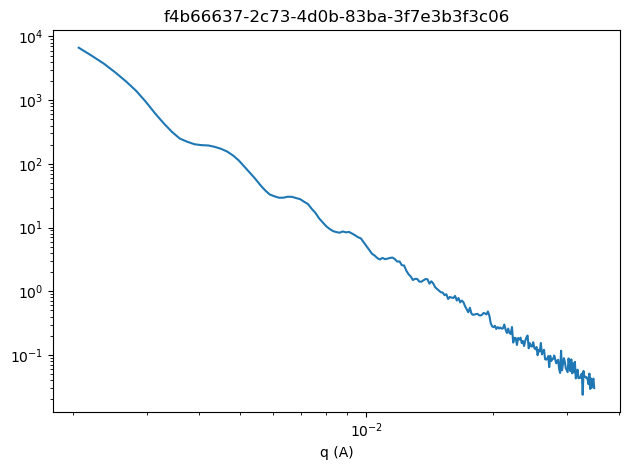

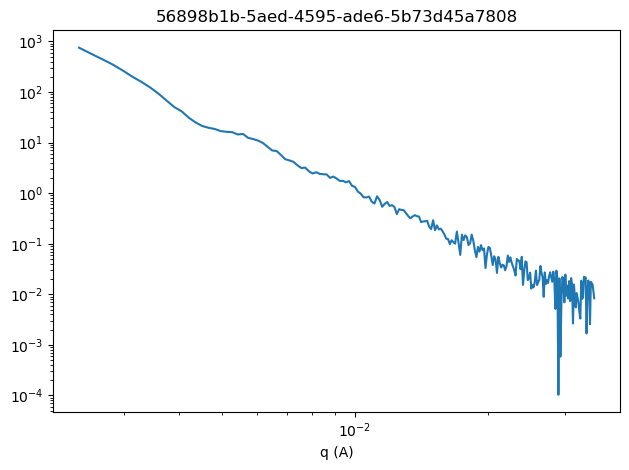

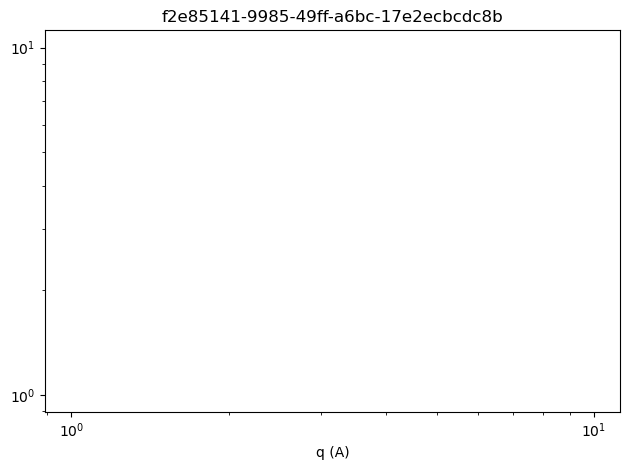

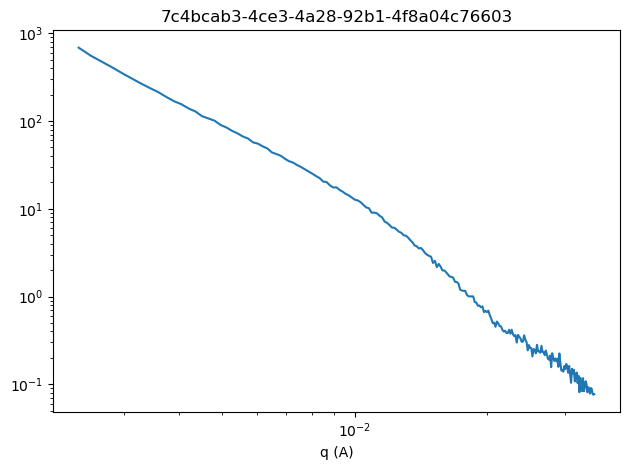

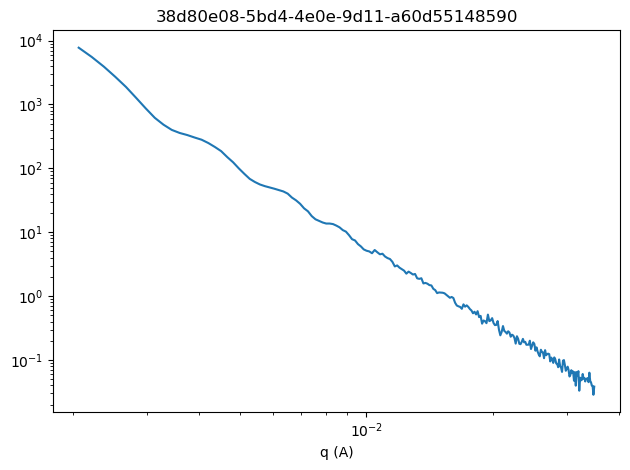

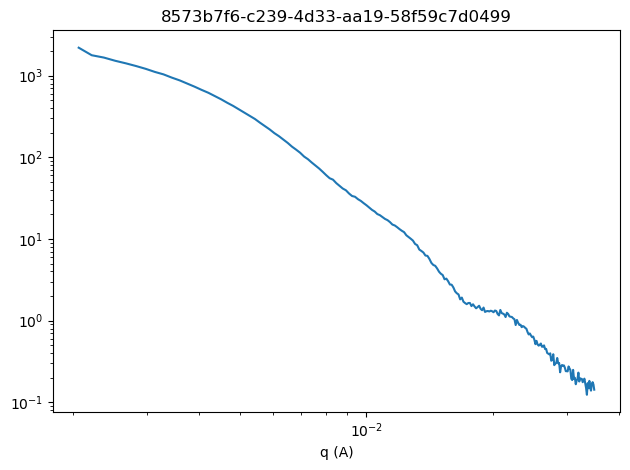

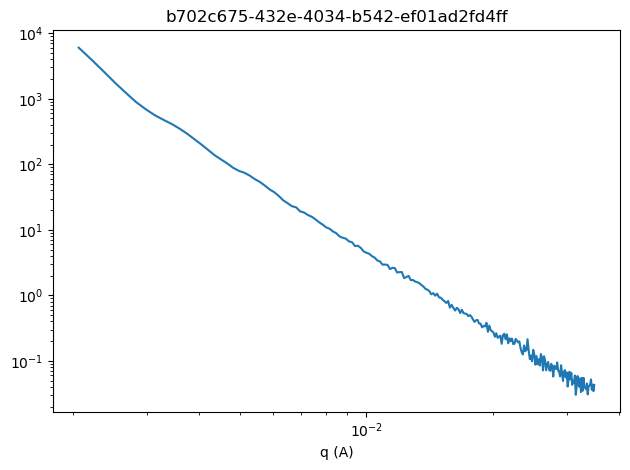

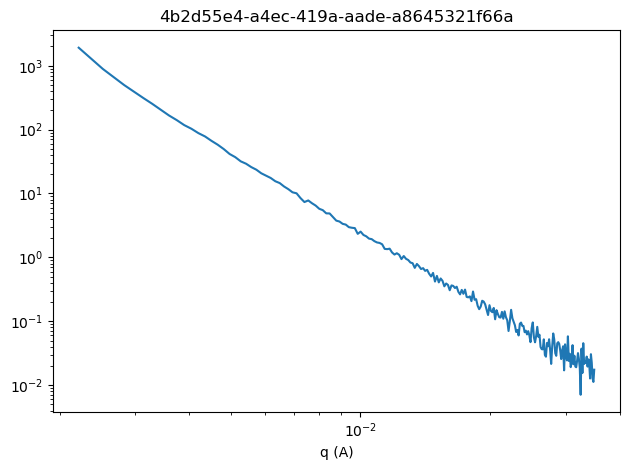

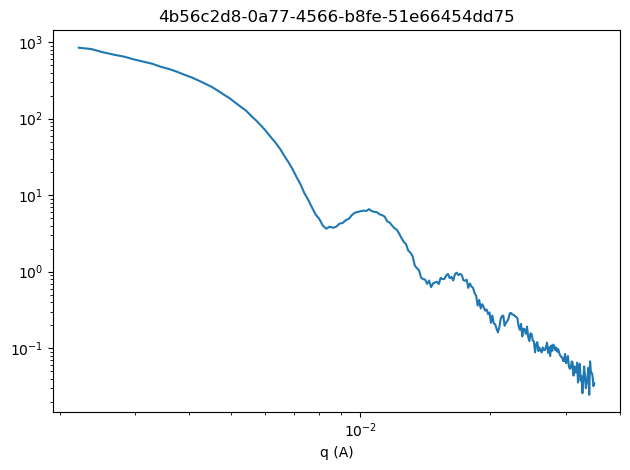

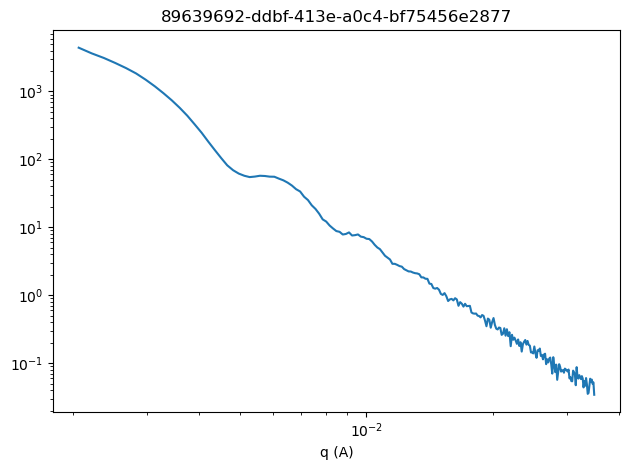

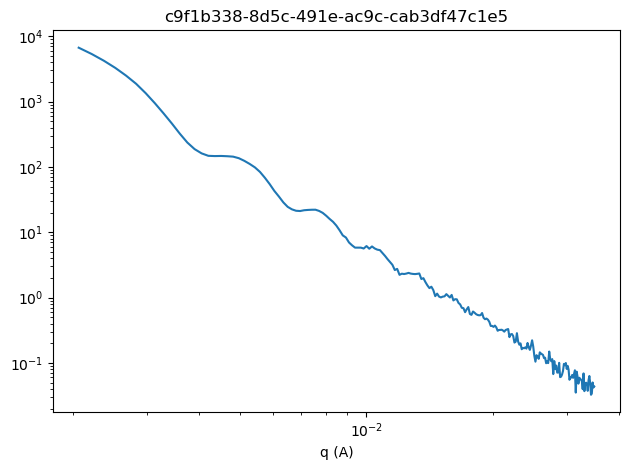

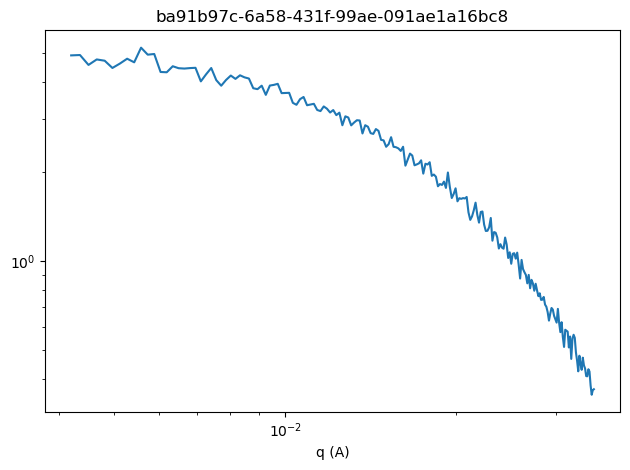

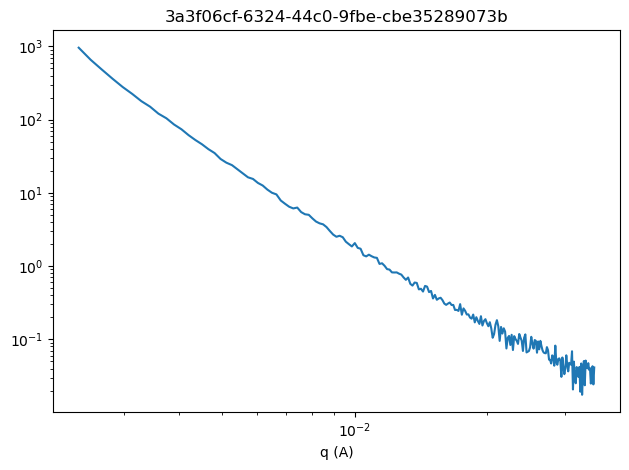

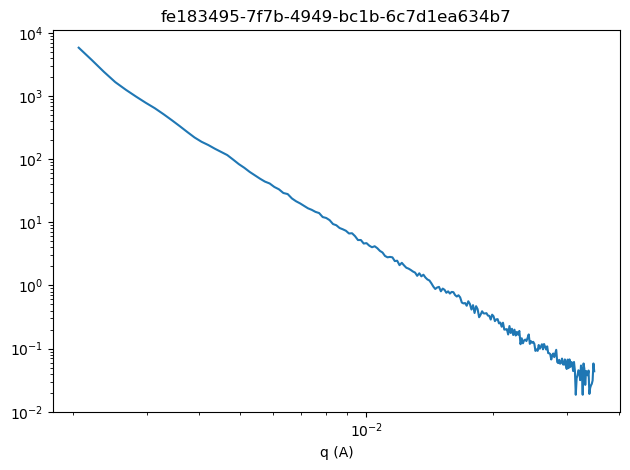

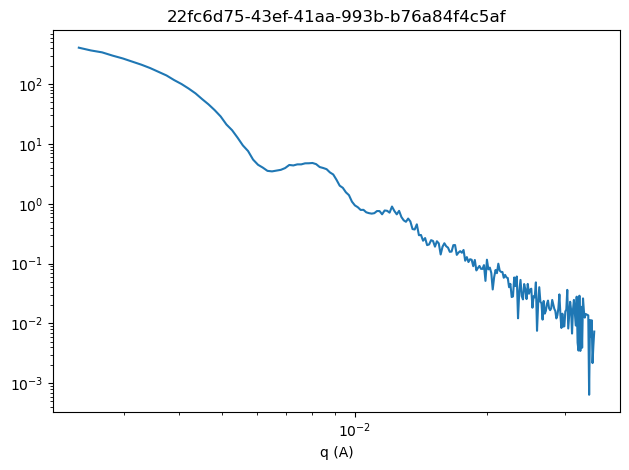

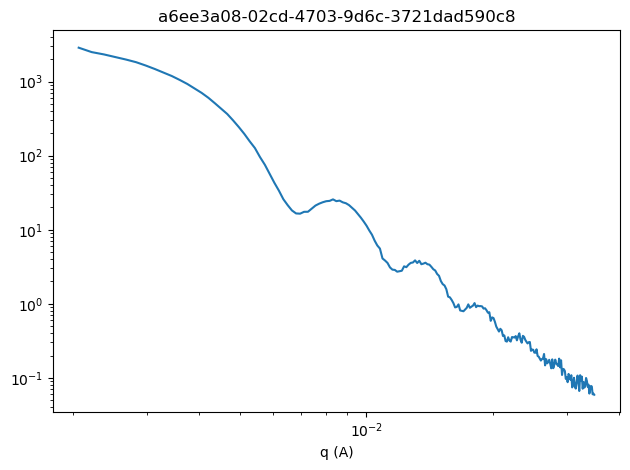

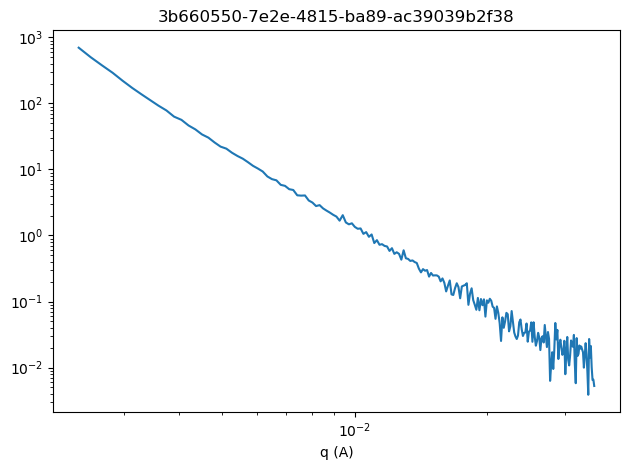

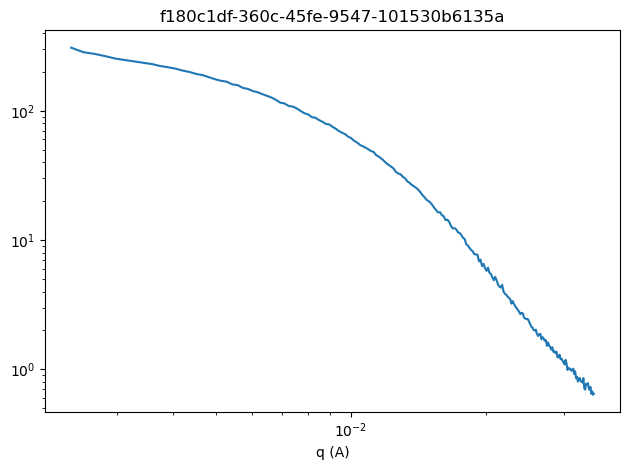

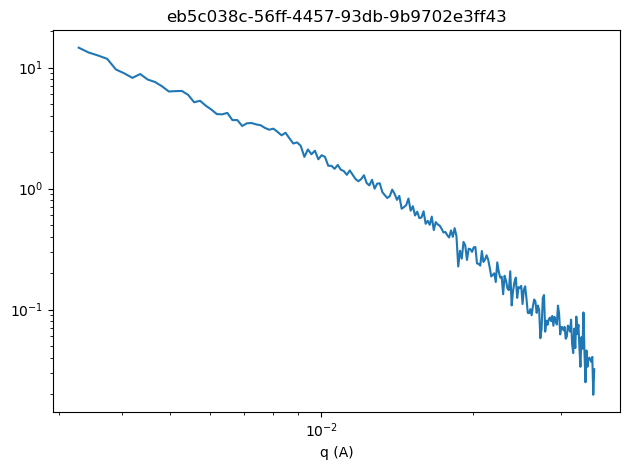

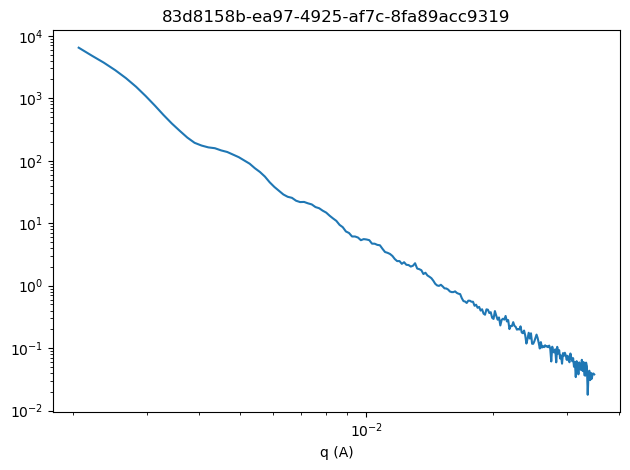

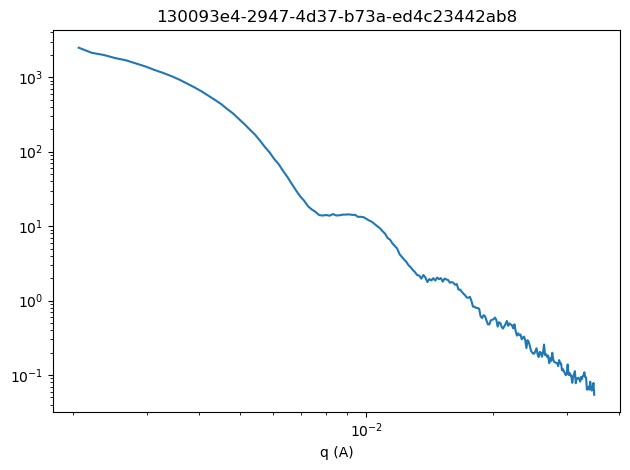

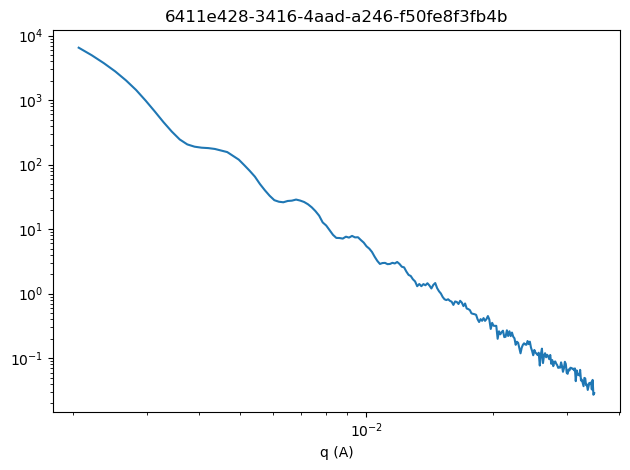

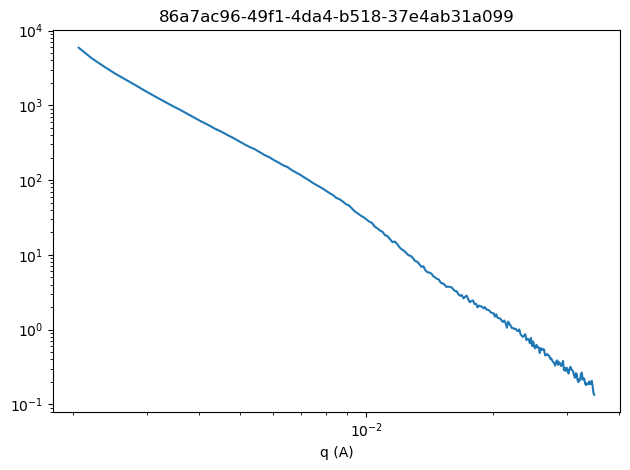

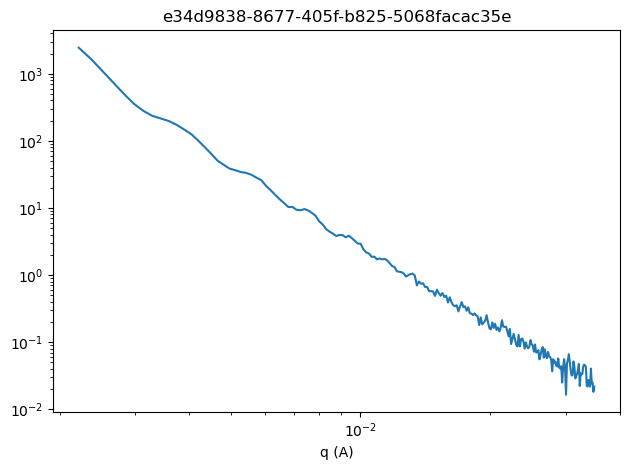

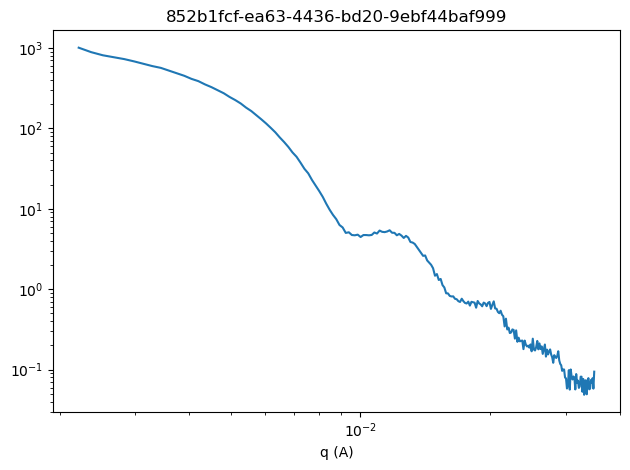

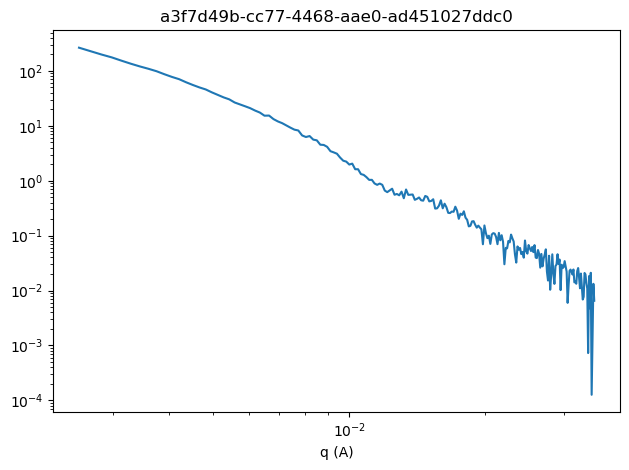

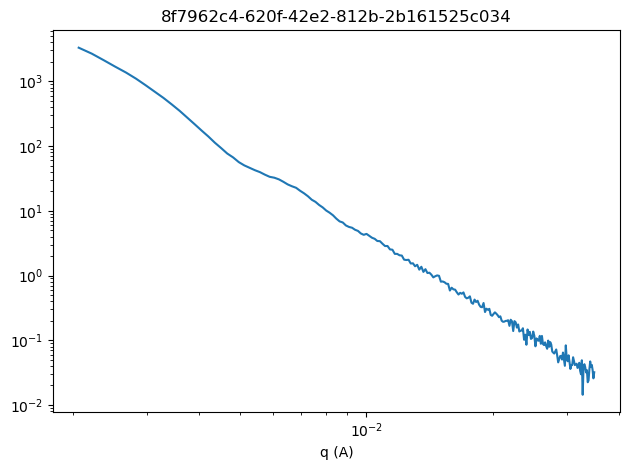

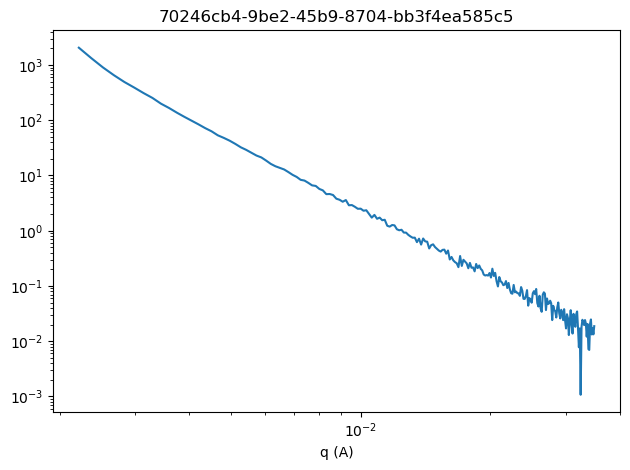

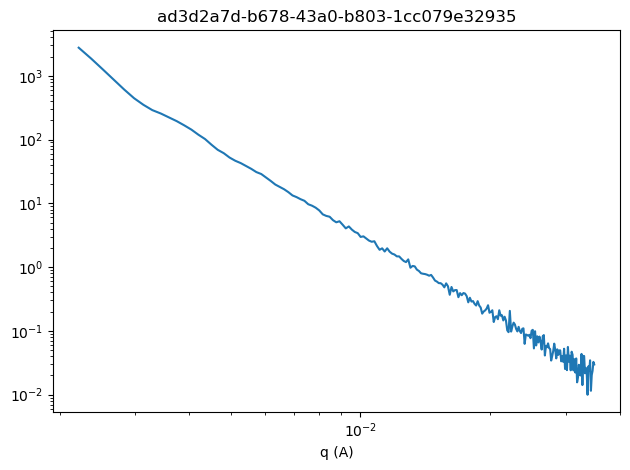

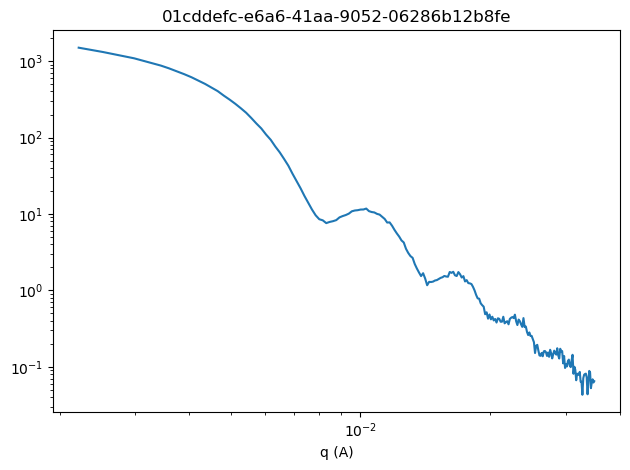

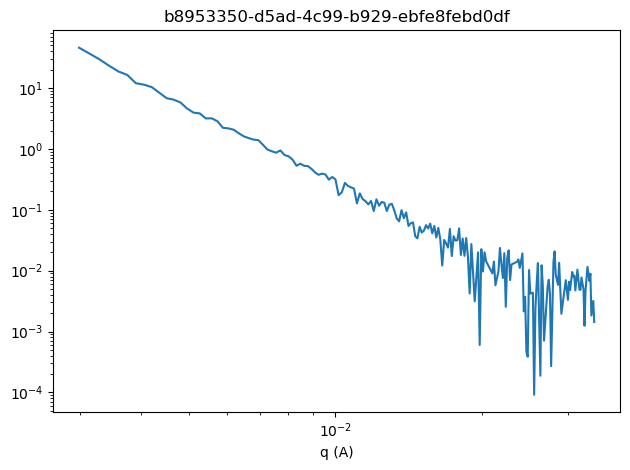

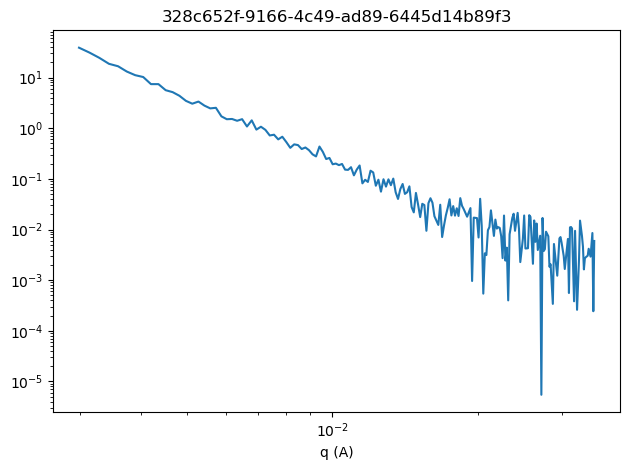

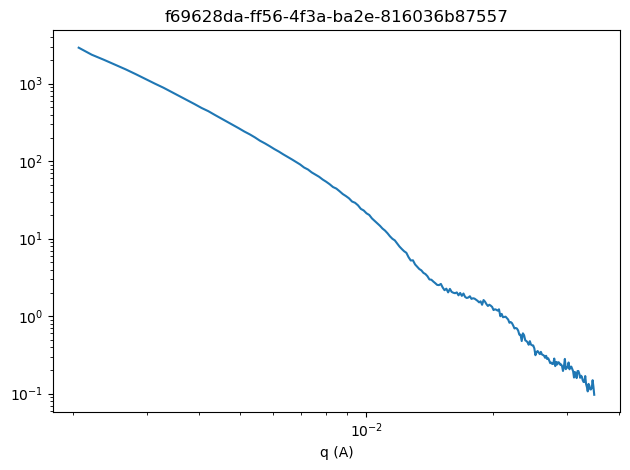

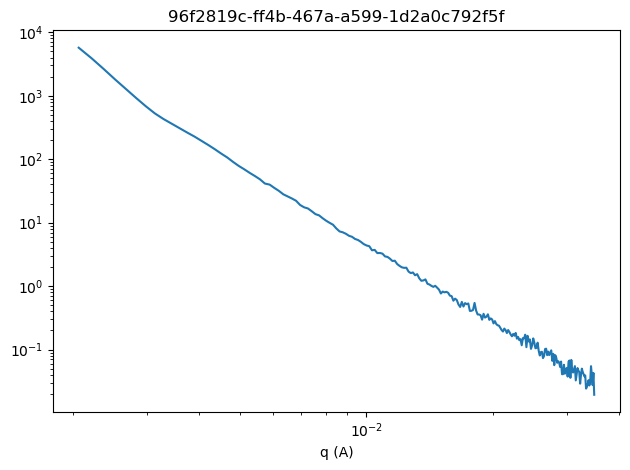

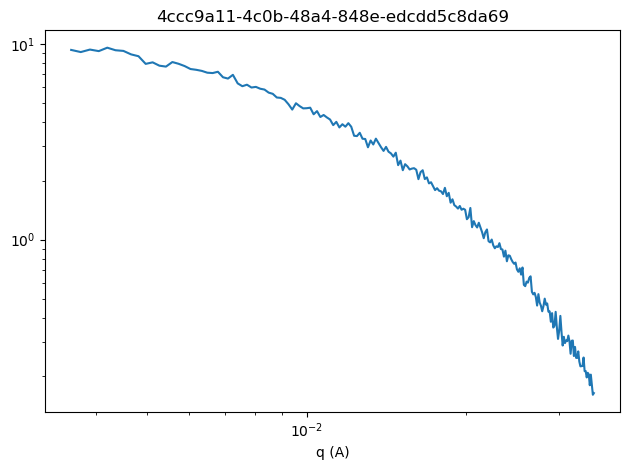

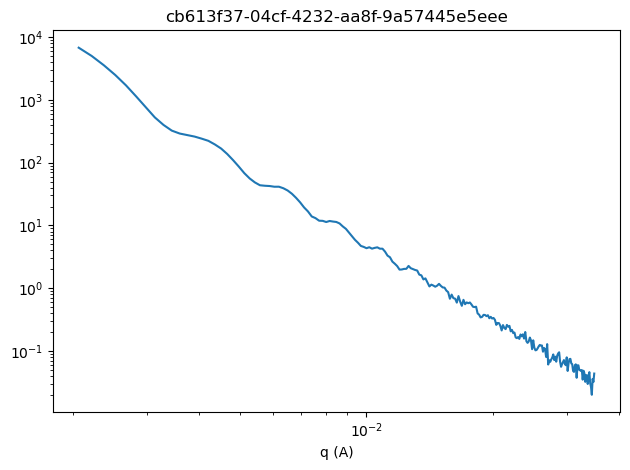

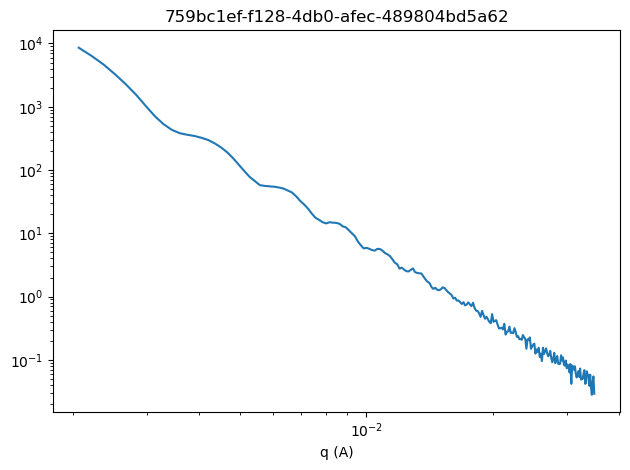

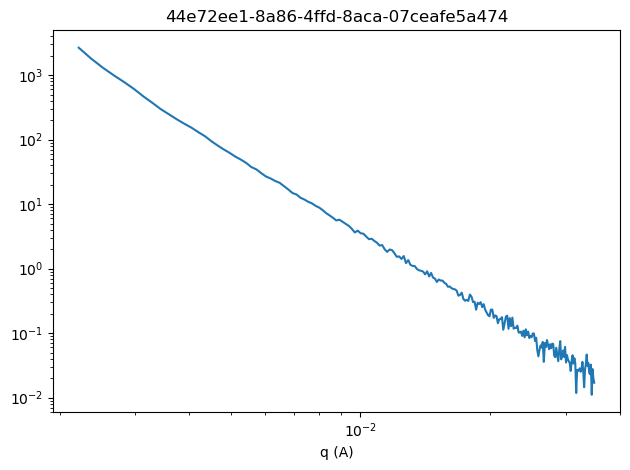

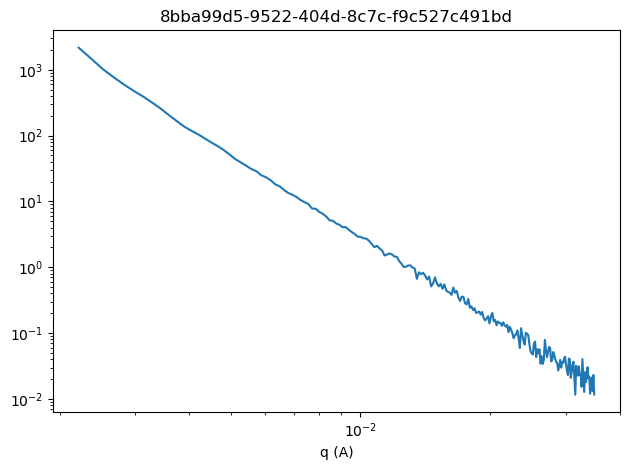

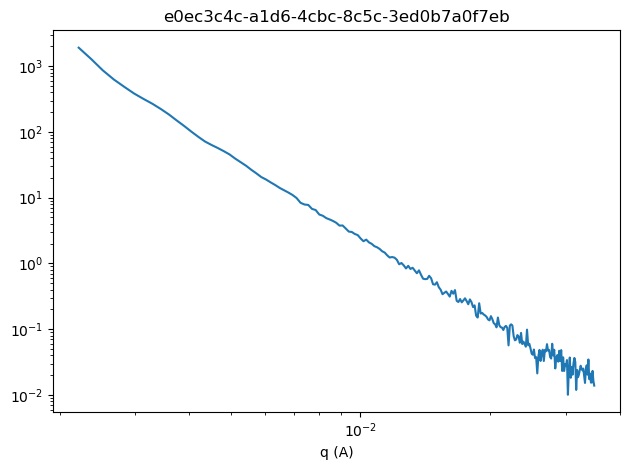

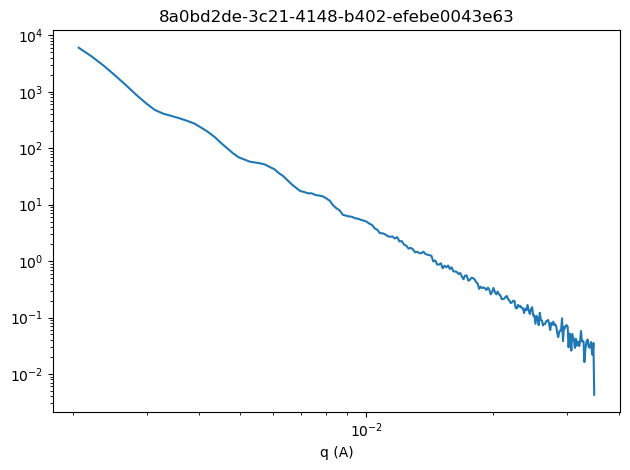

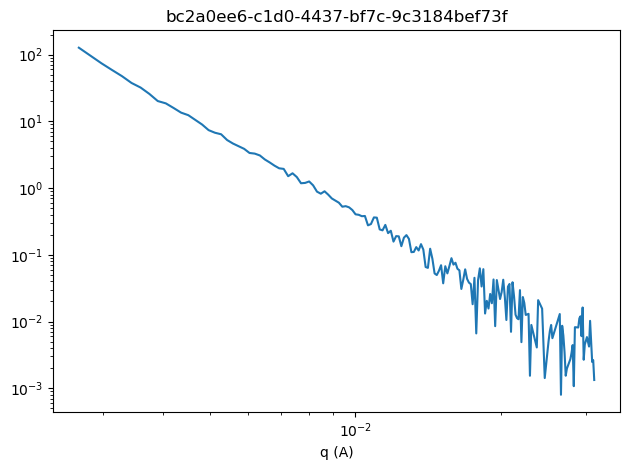

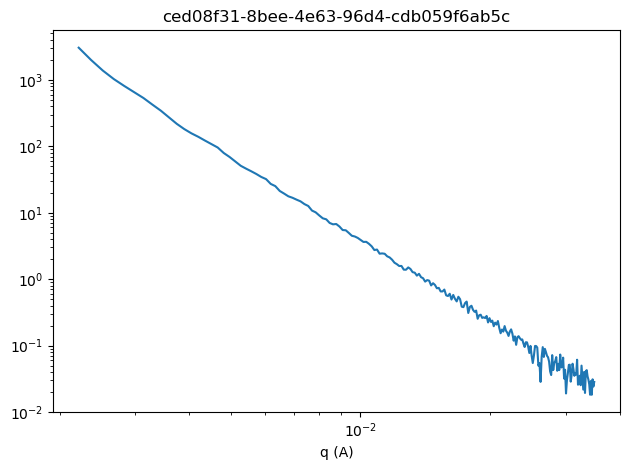

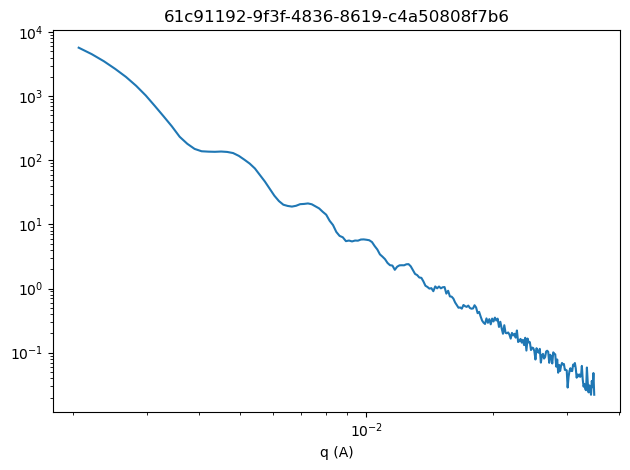

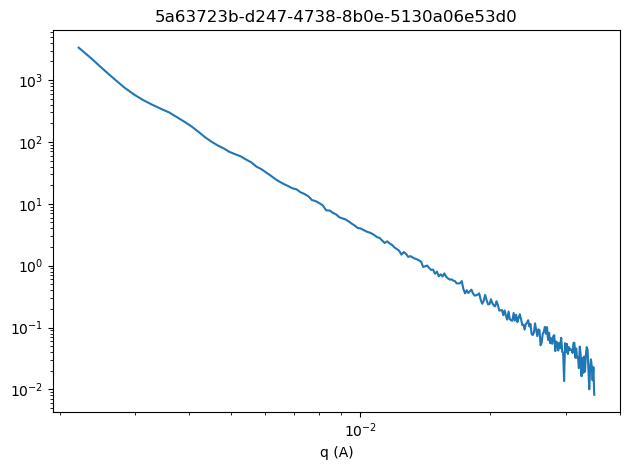

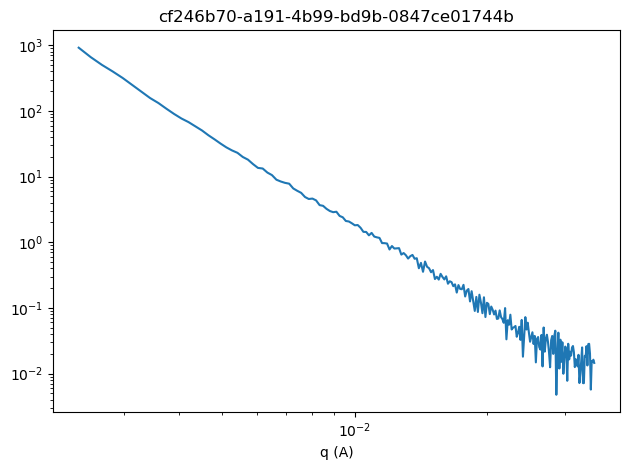

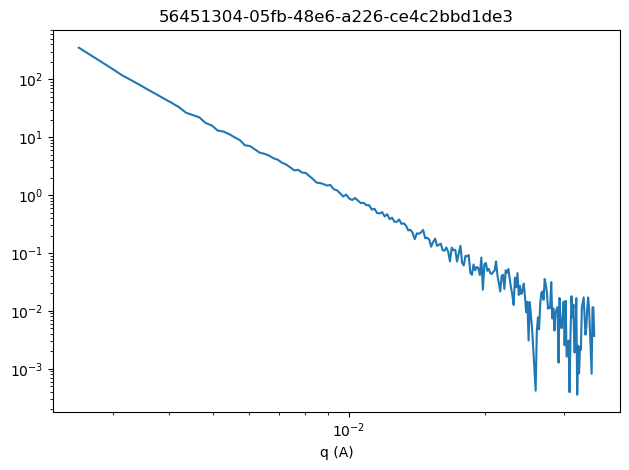

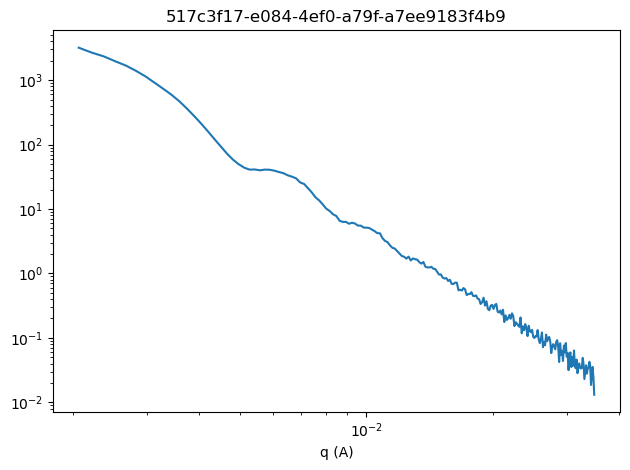

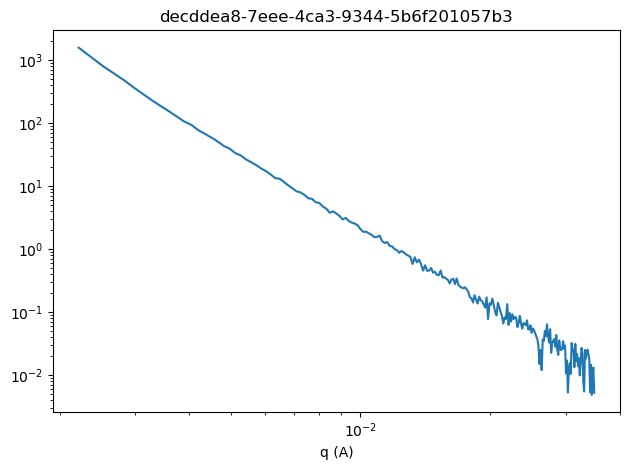

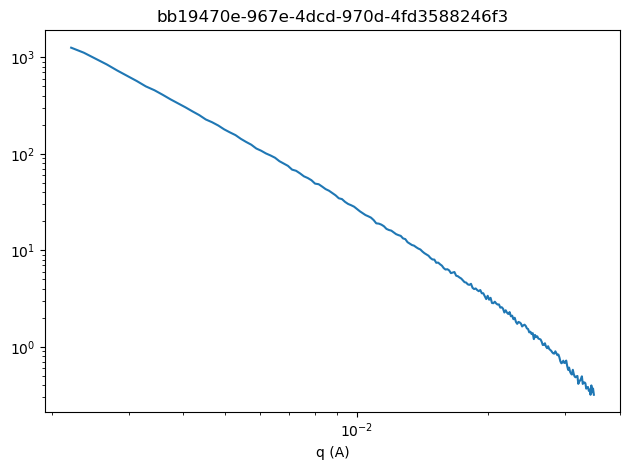

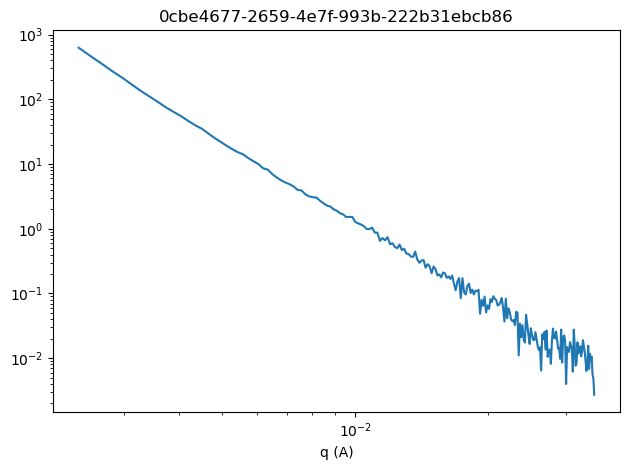

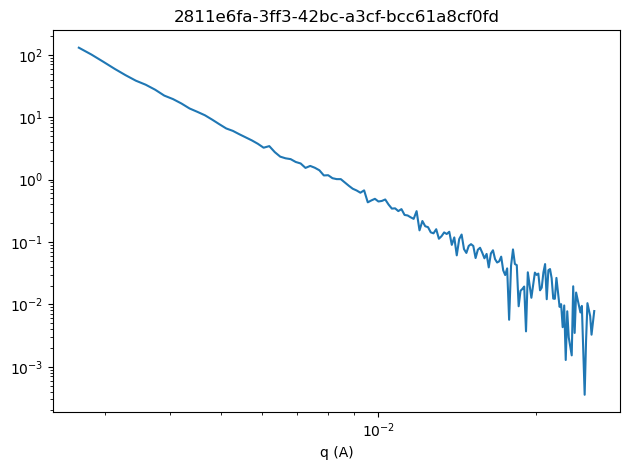

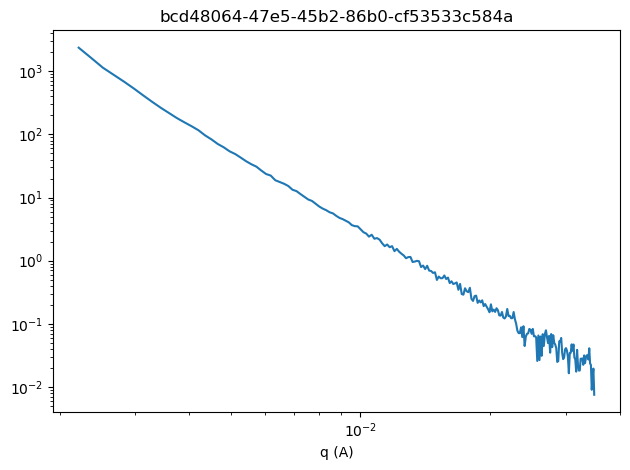

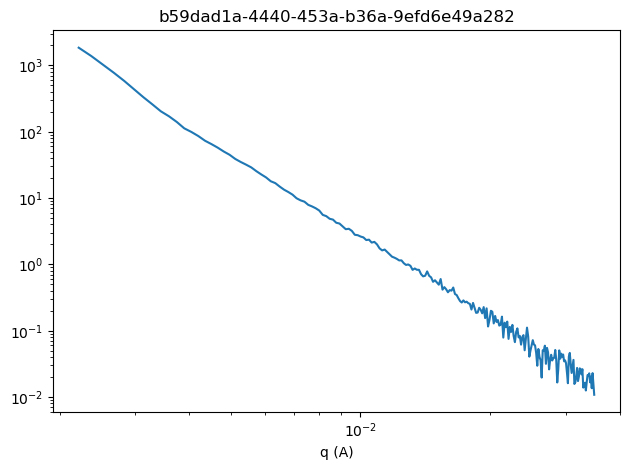

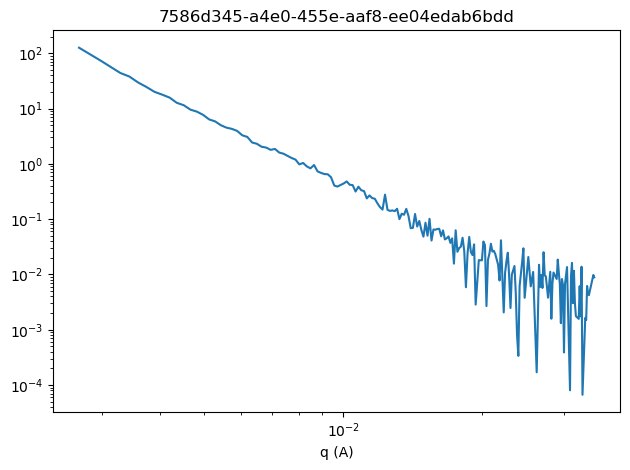

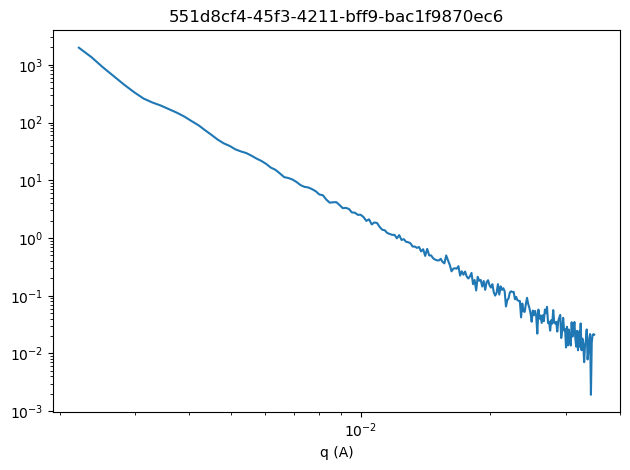

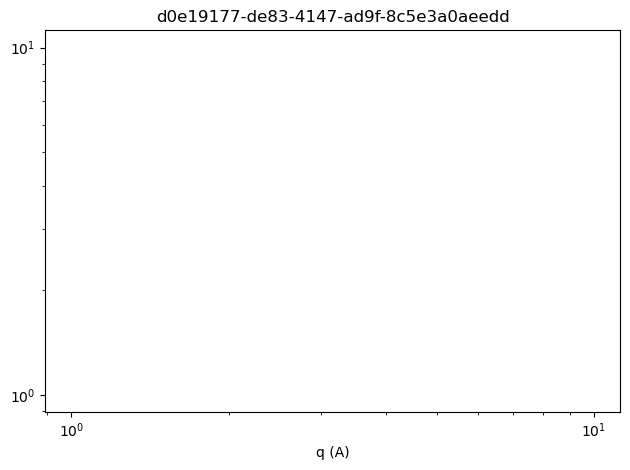

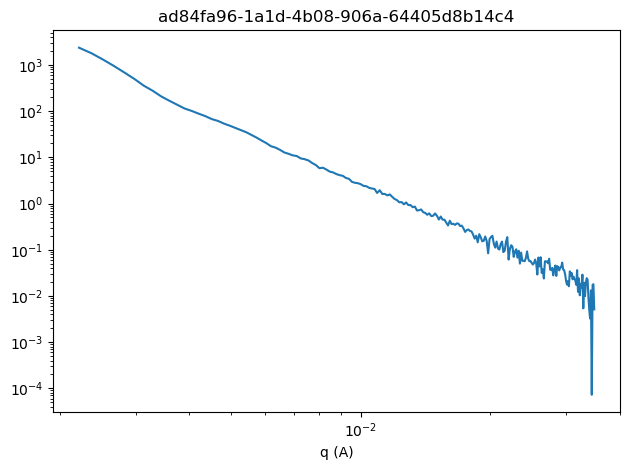

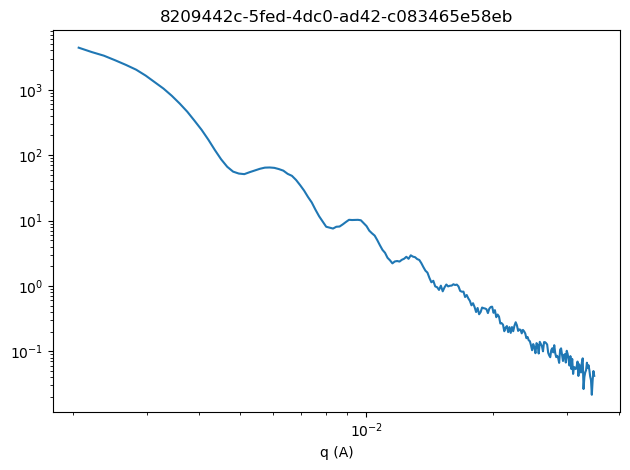

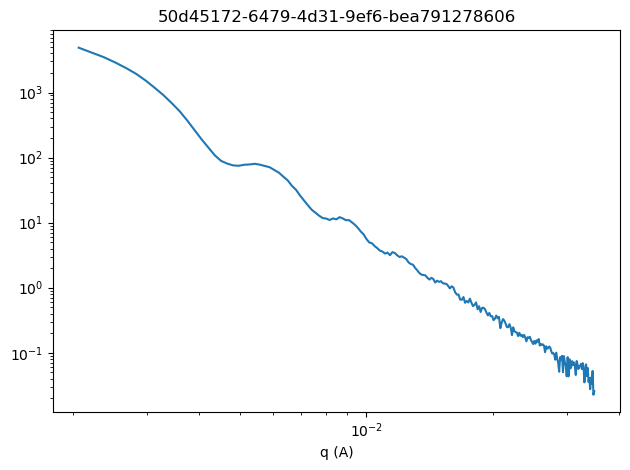

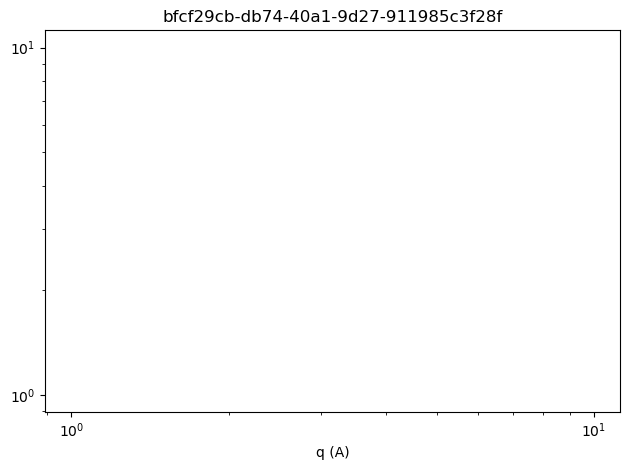

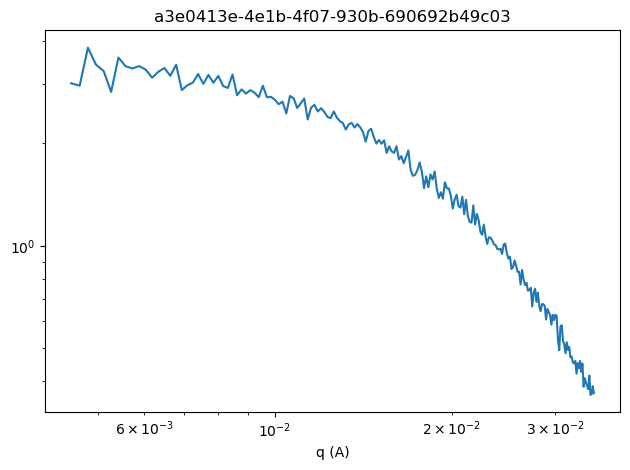

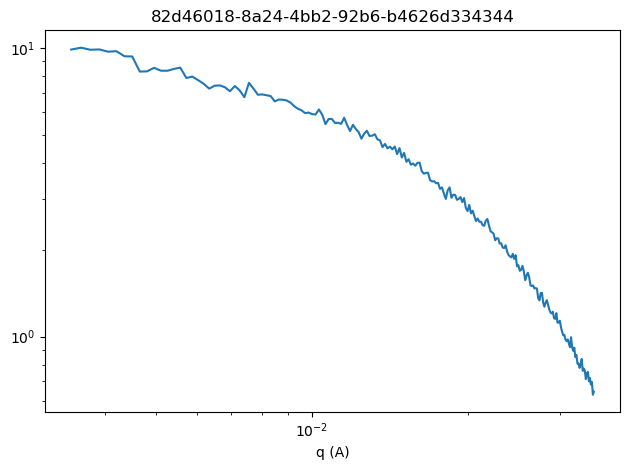

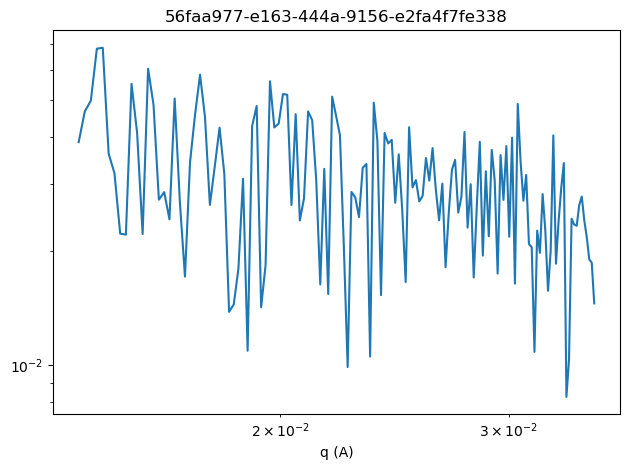

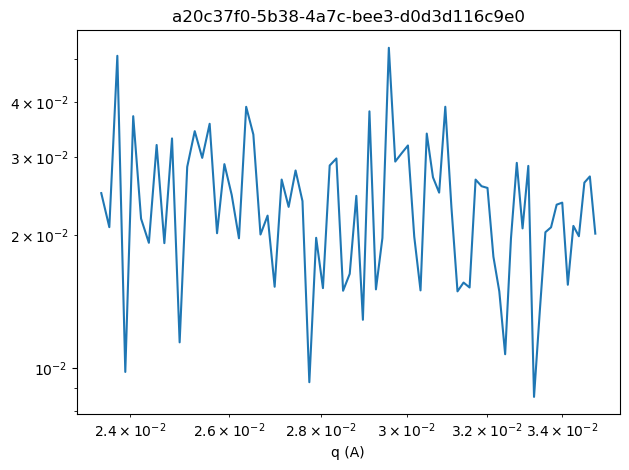

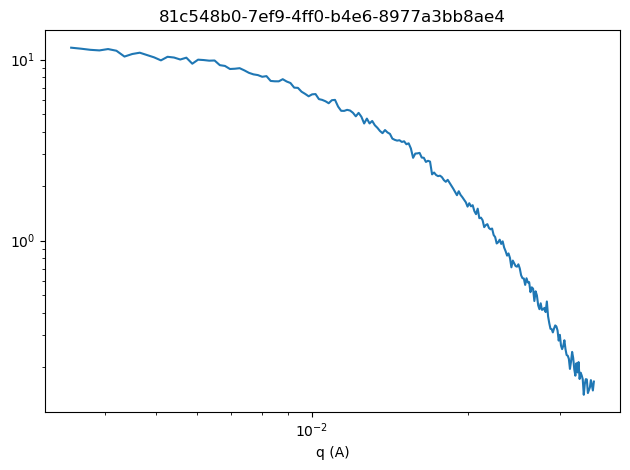

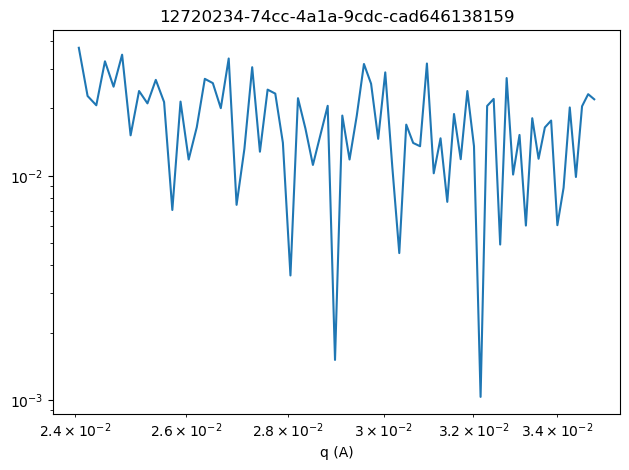

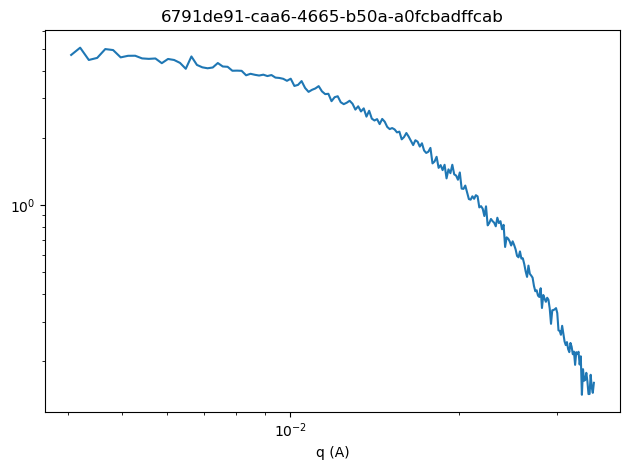

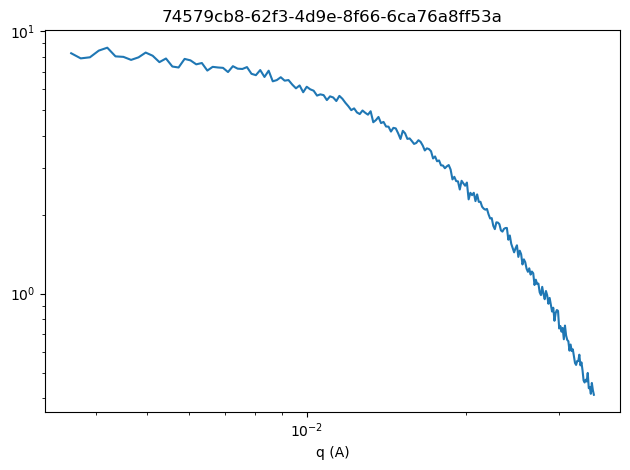

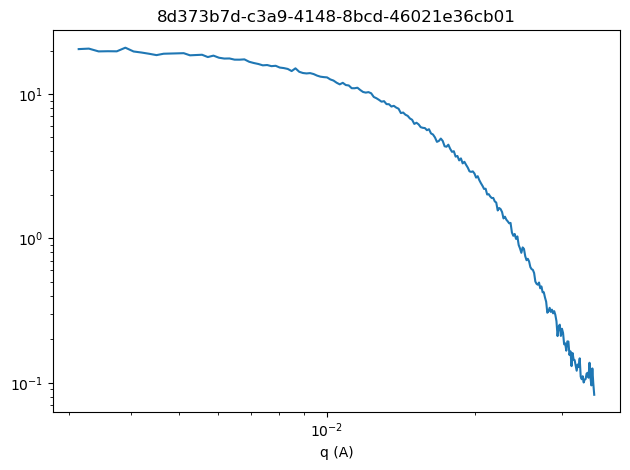

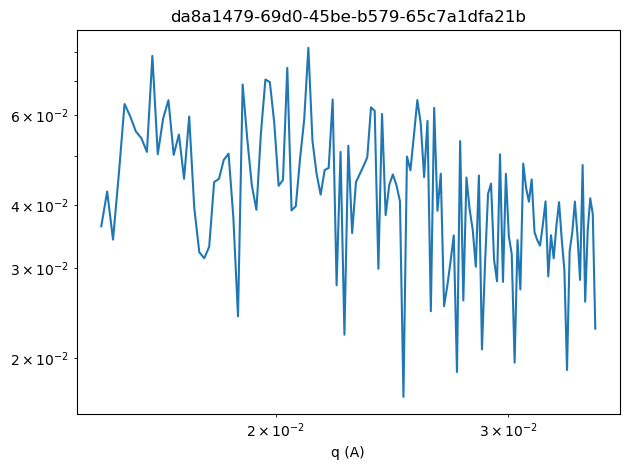

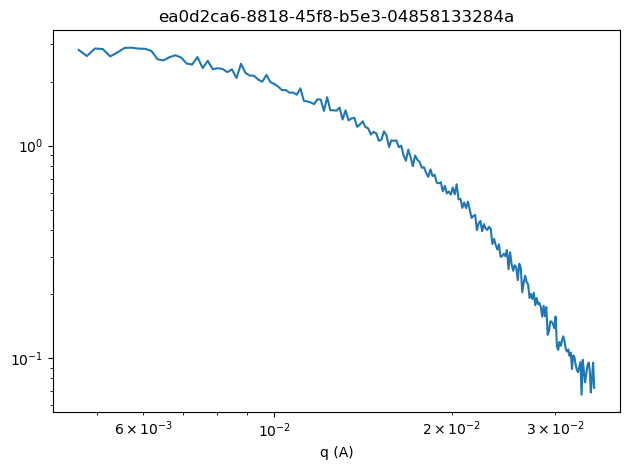

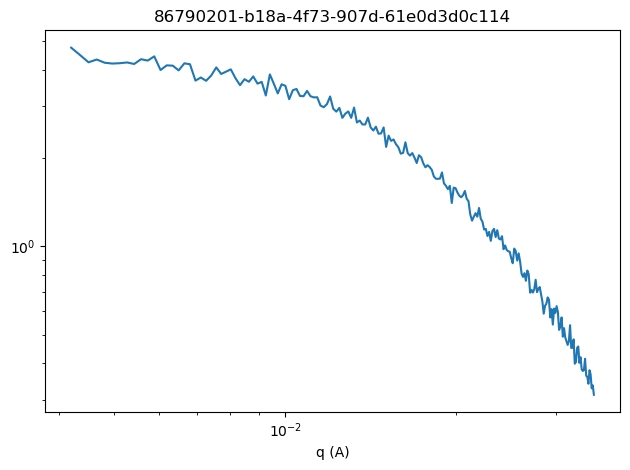

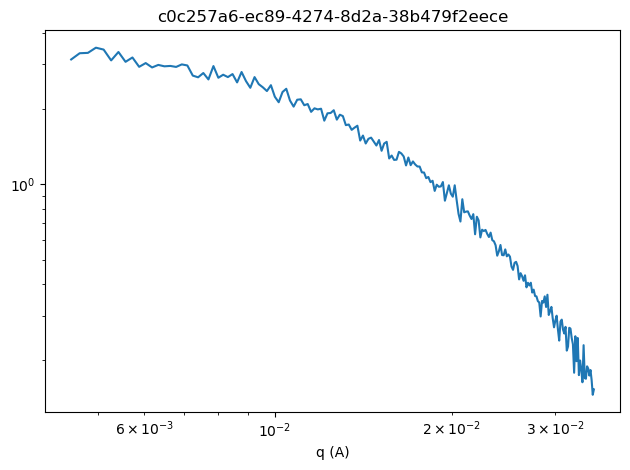

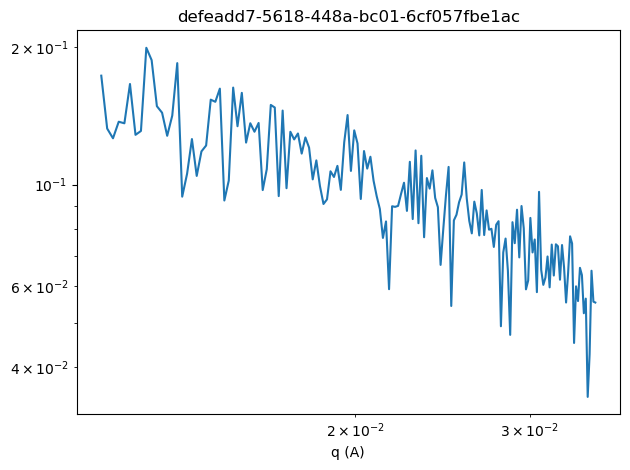

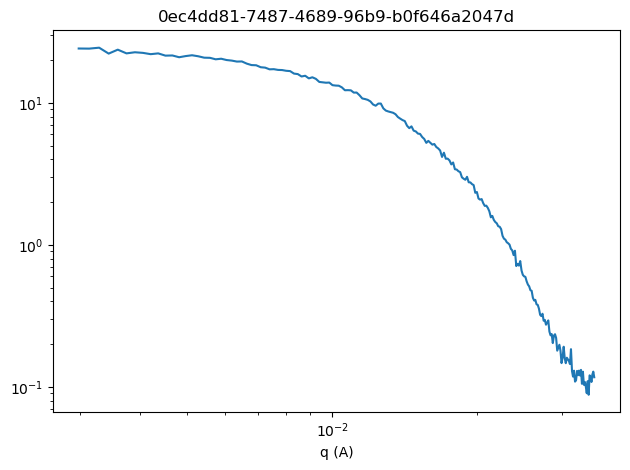

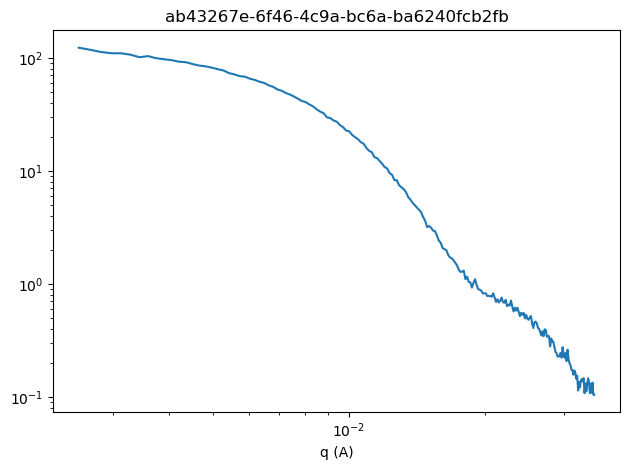

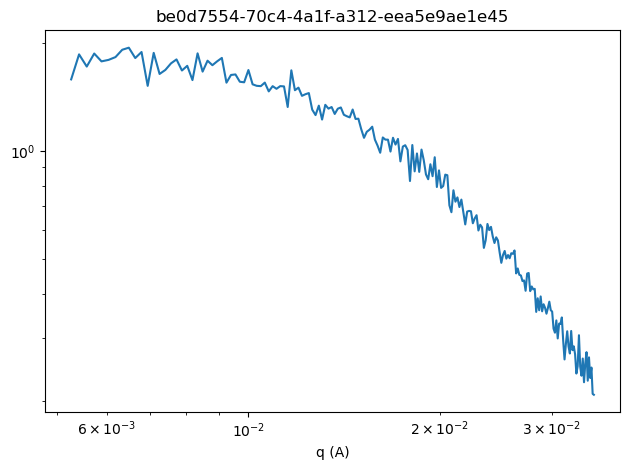

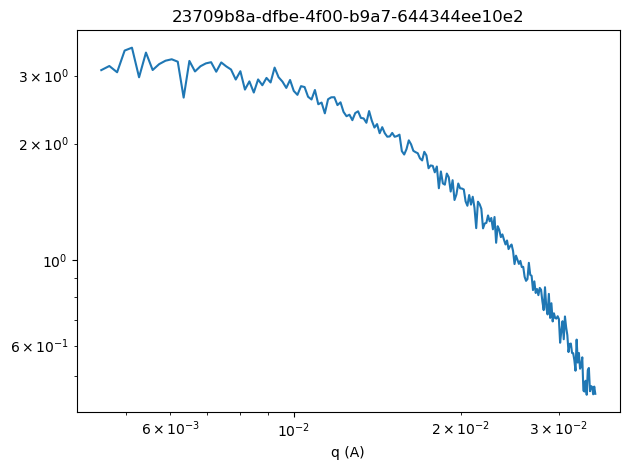

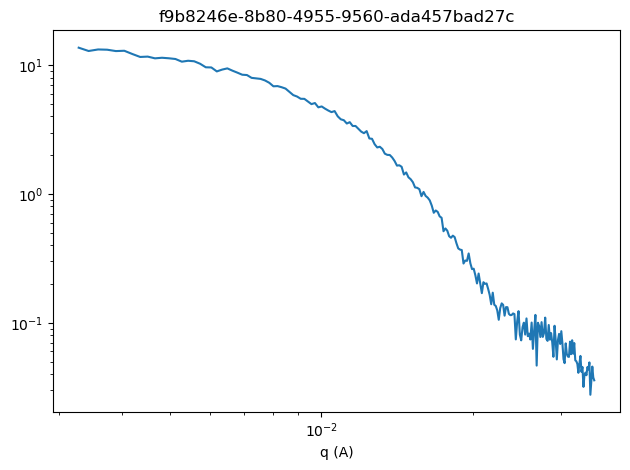

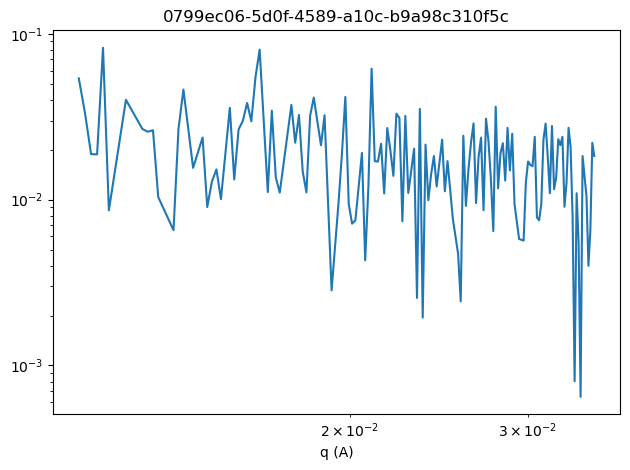

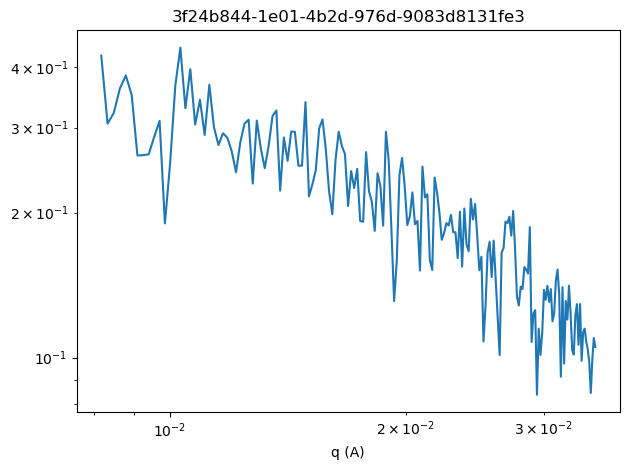

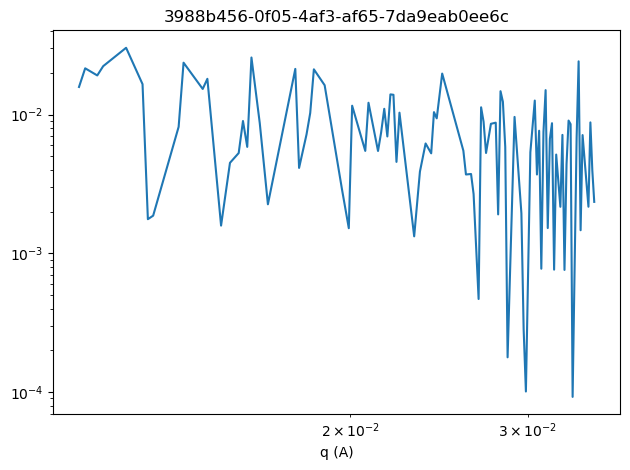

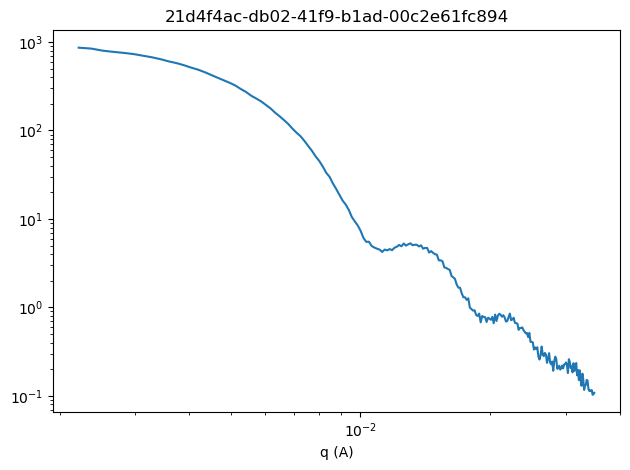

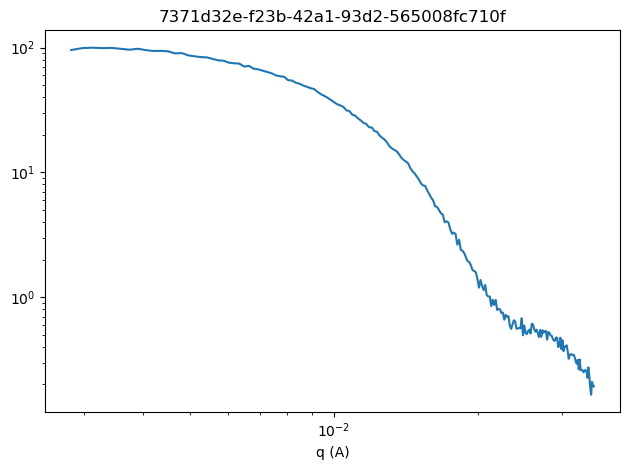

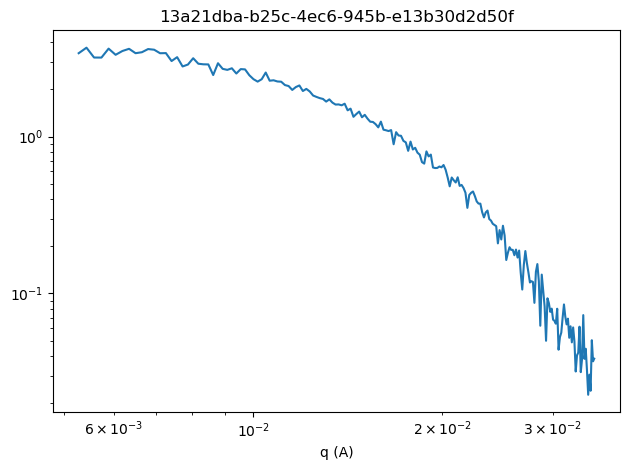

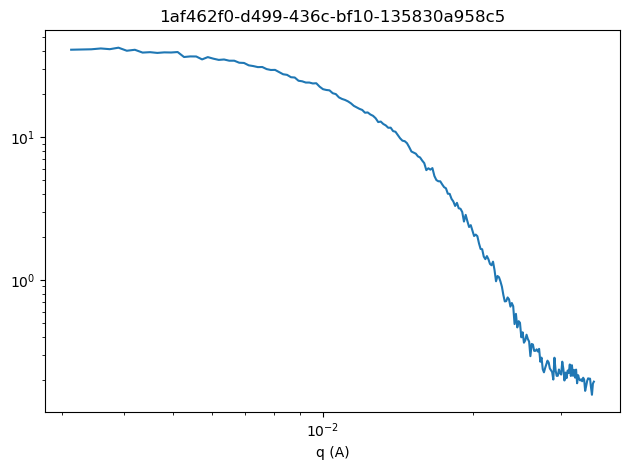

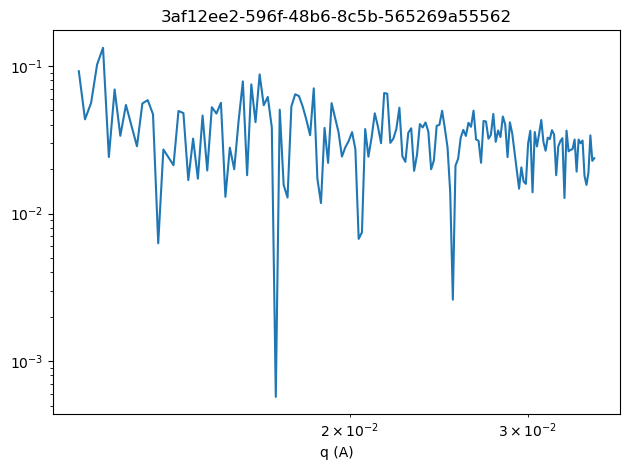

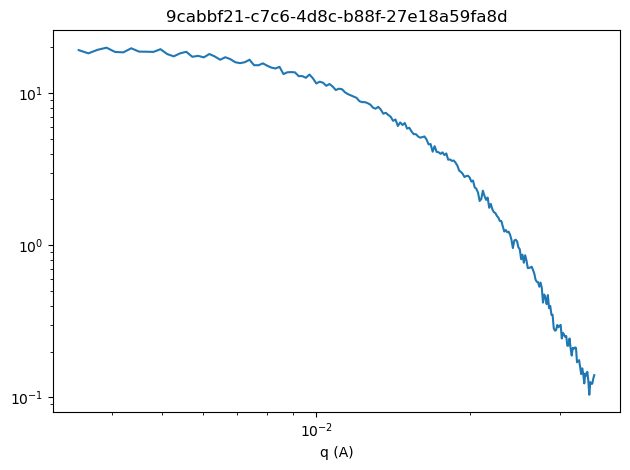

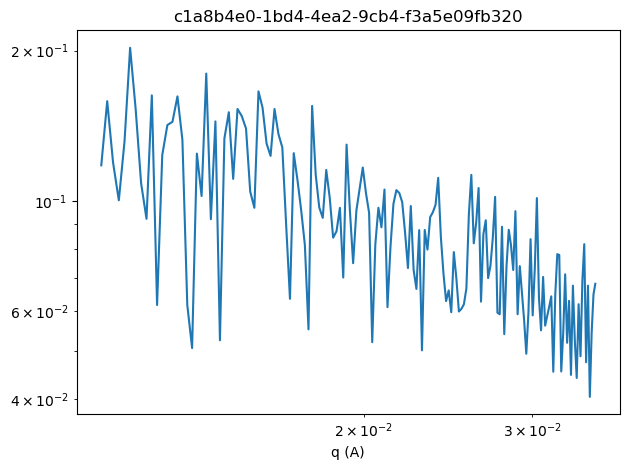

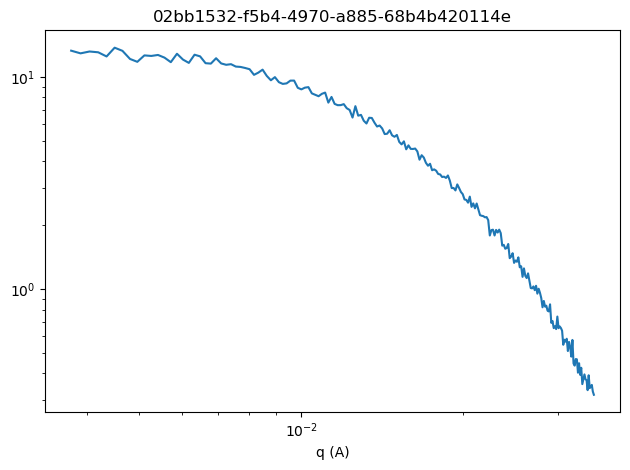

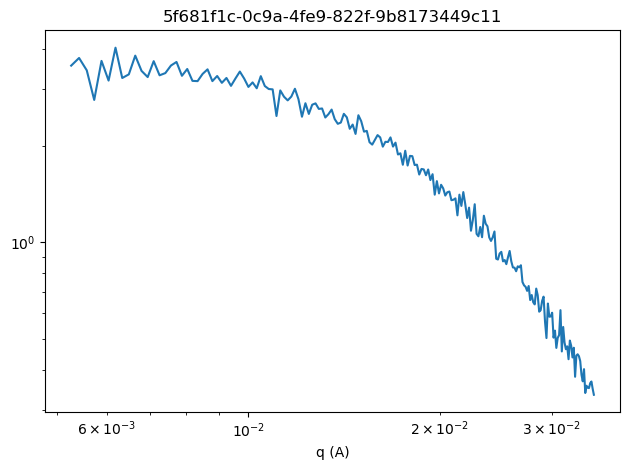

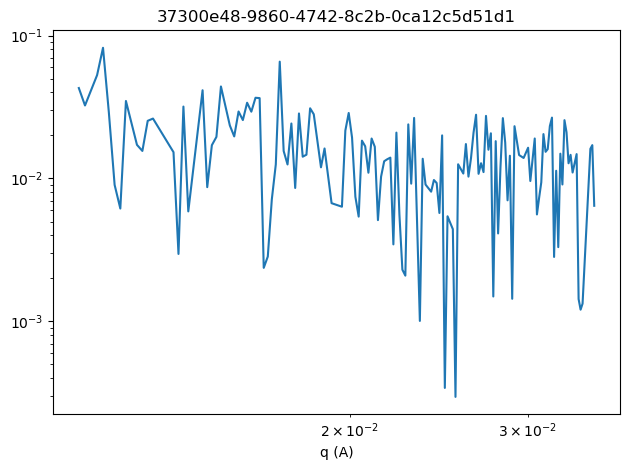

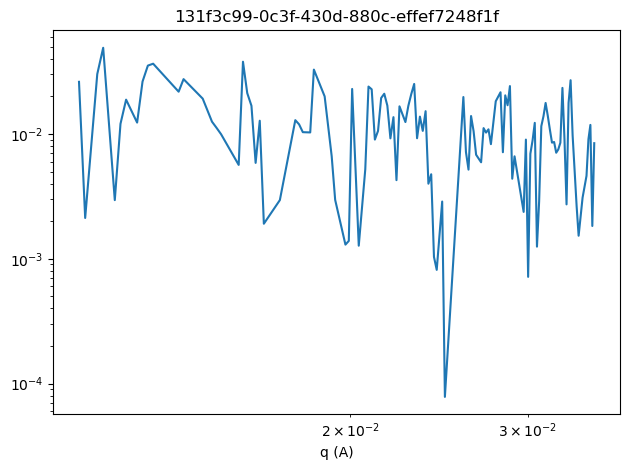

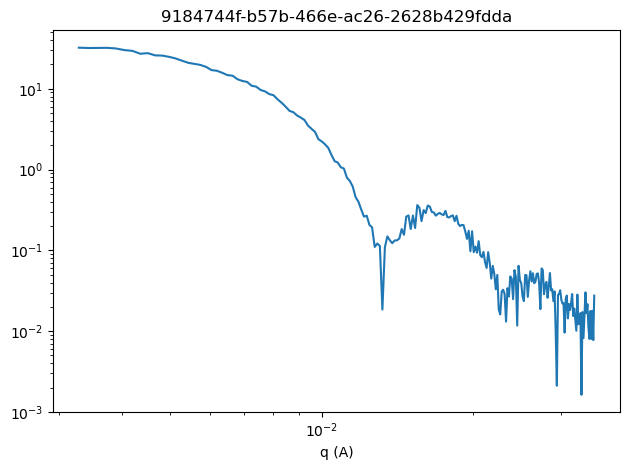

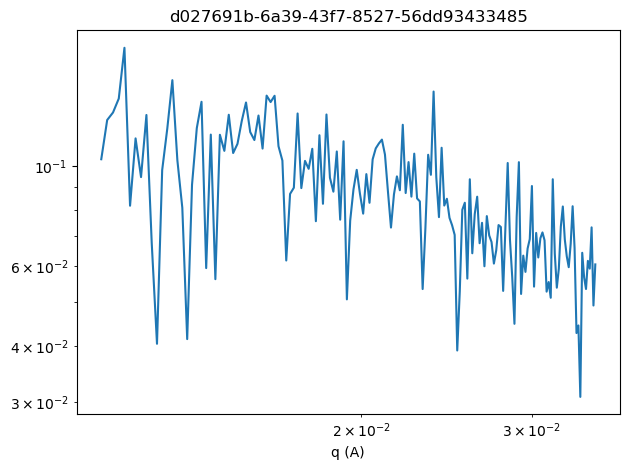

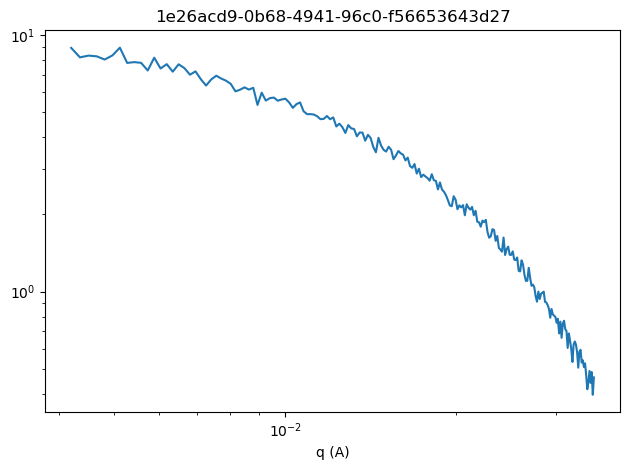

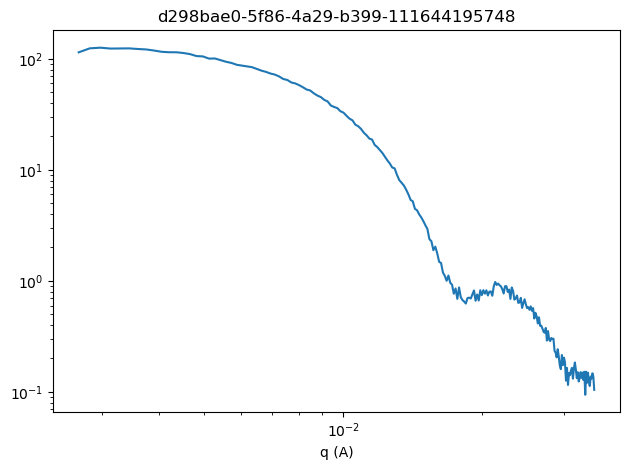

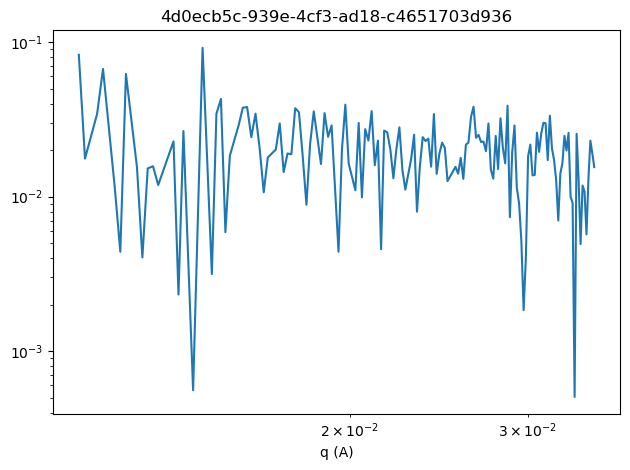

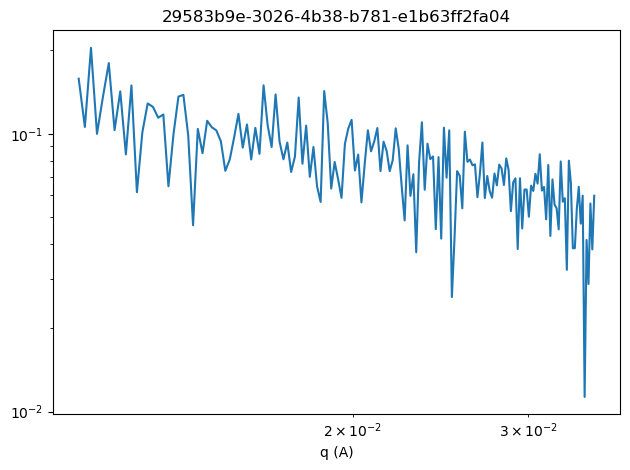

In [38]:
processing_dataset = {}
for uuid_val, data_val in sample_data.items():
   
    data_val = sample_data[uuid_val]
    meas_entry = {}
    meas_entry['original_data'] = data_val[0]
    background = uuid2bkg[uuid_val]
    meas_entry['background'] = background[0]
    # 1. Subtract background and select q range
    subtracted = subtract.chop_subtract(data_val[0], background[0], hiq_thresh=1)
    
    fig, ax = plt.subplots()
    ax.set_title(uuid_val)
    if subtracted is None:
        ax.text(0.5, 0.5, 'Failed Subtraction')
    else:
        subtracted = subtracted[subtracted['q'] < q_max_subtract]
        subtracted = subtracted[~subtracted['I'].isna()]
        subtracted = subtracted[subtracted['I'] > 0] # drop negative values 
        
        ax.loglog(subtracted['q'], subtracted['I'])
        ax.set_xlabel('q (A)')
    plt.tight_layout()
    plt.savefig(f'viz_figs/{uuid_val}.png', dpi = 150)


## prep a df 

In [39]:
synth_data = pd.read_csv('../2024_11_14_OptimRound3/synth_table_ap_distance_11_14_24.csv')

In [40]:
for item in synth_data['uuid'].to_list():
    if 'd298bae' in item:
        print(item)

d298bae0-5f86-4a29-b399-111644195748


In [41]:
synth_data[synth_data['uuid'] == 'd298bae0-5f86-4a29-b399-111644195748']

uuid  teos_volume  ammonia_volume  \
173  d298bae0-5f86-4a29-b399-111644195748    19.379999       28.135001   

     water_volume  ethanol_volume  dilution_volume_fraction  silica_mass_conc  \
173     45.475003     1607.009996                   1.95802          3.068406   

     silica_mass_fraction  ethanol_dilute_vol  sample_dilute_vol dilute_well  \
173              0.003843                 0.0             1700.0          E5   

     target_volume  teos_vol_frac  ammonia_vol_frac  water_vol_frac  \
173         1700.0         0.0114           0.01655         0.02675   

     ethanol_vol_frac  ap_distance experiment_status  rank  
173            0.9453      1.56622          complete  78.0

In [42]:
filepaths = [f'https://upconverting.blob.core.windows.net/silica-np-saxs/{uuid}.png' for uuid in synth_data['uuid']] 

In [43]:
synth_data['image'] = filepaths

In [44]:
chart = alt.Chart(synth_data, width = 600, height = 500).mark_circle(size=100).encode(
    x = 'teos_vol_frac',
    y = 'water_vol_frac',
    color = 'ap_distance',
    tooltip=['uuid', 'image', 'ap_distance'])

#chart['usermeta'] = {
#    "embedOptions": {
#        'loader': {'target': '_blank'}
#    }
#}

In [45]:
chart

alt.Chart(...)

In [48]:
chart = alt.Chart(synth_data, width = 600, height = 500).mark_circle(size=100).encode(
    x = 'teos_vol_frac',
    y = 'ammonia_vol_frac',
    color = 'ap_distance',
    tooltip=['uuid', 'image', 'ap_distance', 'water_vol_frac'])

In [49]:
chart

alt.Chart(...)

### 3D viz

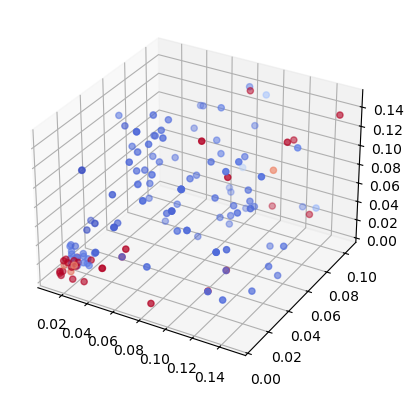

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(synth_data['teos_vol_frac'], synth_data['ammonia_vol_frac'], synth_data['water_vol_frac'], c = synth_data['ap_distance'], cmap = plt.cm.coolwarm)

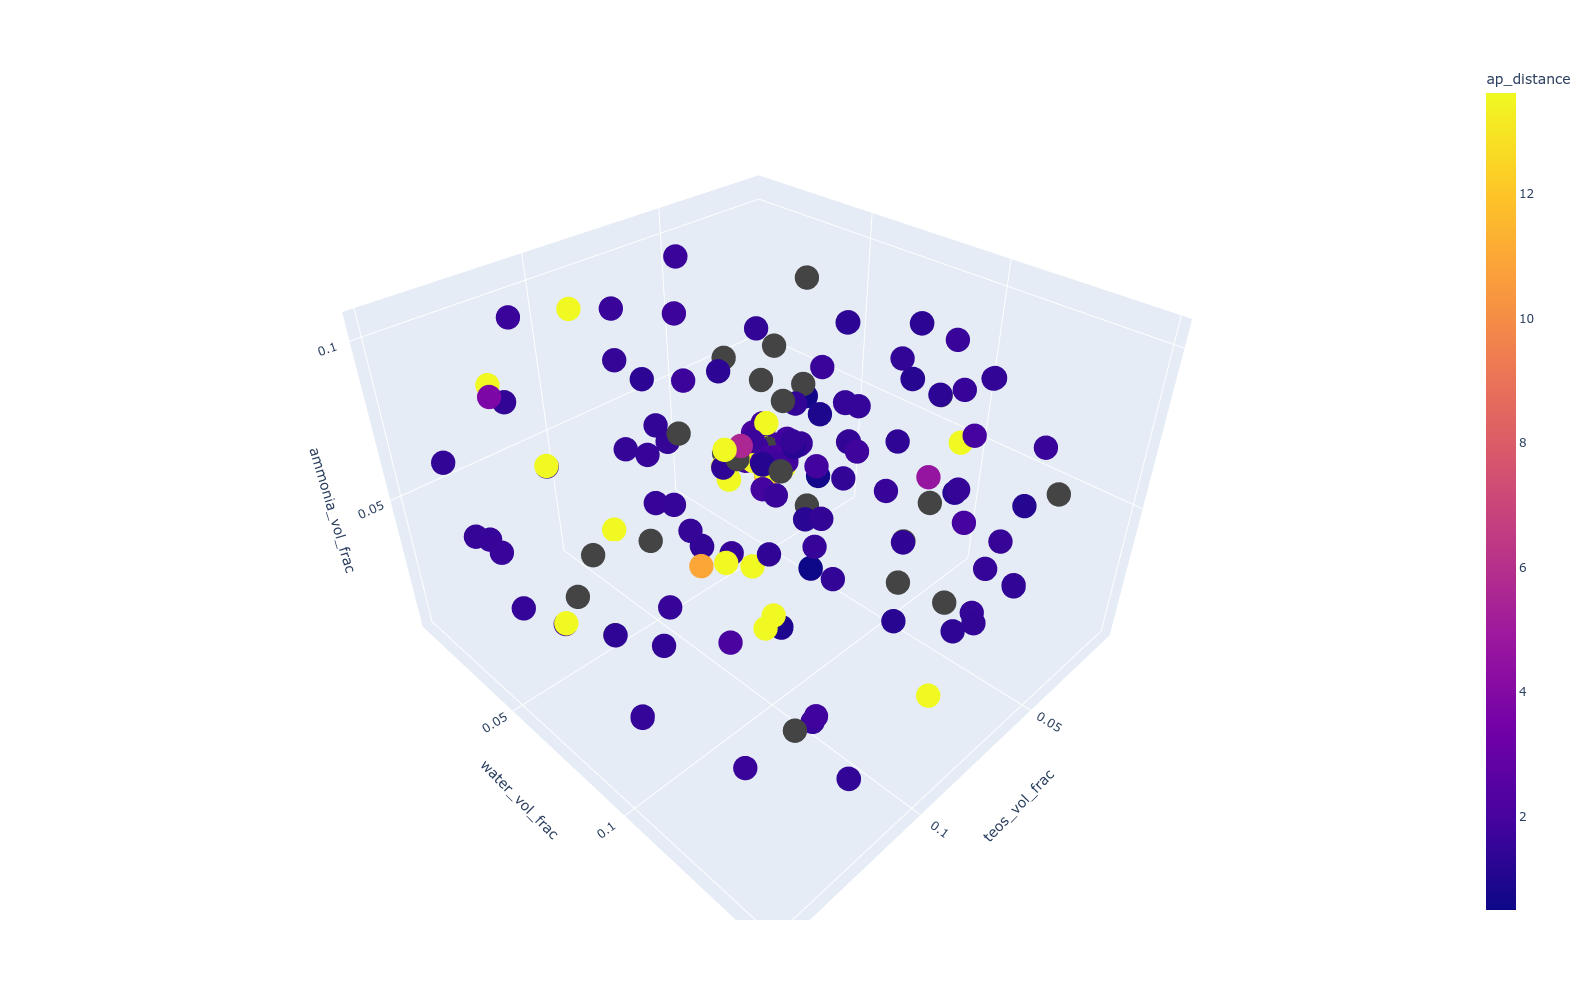

In [20]:
import plotly.express as px
fig = px.scatter_3d(synth_data, x='teos_vol_frac', y='water_vol_frac', z='ammonia_vol_frac',
              color='ap_distance', width=1000, height = 1000)
fig.show()